# Tweets analysis

## Importing libraries and data

In [1]:
import re
import numpy as np
import pandas as pd
from os import path

#plotting
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx

#word clouds
import heapq
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from tqdm import tqdm
import unicodedata

#sentiment analysis
from textblob import TextBlob

#text preprocessing
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
import emoji

#hide warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud, ImageColorGenerator
from os import path, getcwd
from PIL import Image

import pymannkendall as mk

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexandralugova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexandralugova/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#df = pd.read_csv('datasets/twitter_data_sent_full.csv',parse_dates=['created','date','year'])
#df = df.rename(columns={'sentiment_':'sentiment','compound_':'compound'})
#df = df.loc[df.country != 'France']

In [2]:
df = pd.read_csv('datasets/twitter_data_full.csv',parse_dates=['created'])

df['date'] = pd.to_datetime(df['created']).dt.date
df['date'] = pd.to_datetime(df['date'])
df['quarter'] = pd.to_datetime(df['created']).dt.to_period('Q')
df['year'] = pd.to_datetime(df['created']).dt.year

df = df.set_index('date')
df['covid'] = 'pic'
df.loc['2017-03-01':'2020-03-01','covid'] = 'before pic'
df.loc['2021-04-01':'2022-06-01','covid'] = 'after pic'
df = df.sort_values(by='created').reset_index()

df

/Users/alexandralugova/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


date                   created              user_id  \
0     2017-03-01 2017-03-01 00:18:37+00:00            106796486   
1     2017-03-01 2017-03-01 04:44:02+00:00             36811246   
2     2017-03-01 2017-03-01 04:47:07+00:00            575617243   
3     2017-03-01 2017-03-01 05:01:47+00:00           3306508769   
4     2017-03-01 2017-03-01 07:12:43+00:00           2757862423   
...          ...                       ...                  ...   
37102 2022-05-30 2022-05-30 08:43:47+00:00            217510653   
37103 2022-05-30 2022-05-30 08:48:59+00:00            150782067   
37104 2022-05-30 2022-05-30 17:09:51+00:00  1508127786082267136   
37105 2022-05-30 2022-05-30 20:35:23+00:00           4692838782   
37106 2022-05-30 2022-05-30 21:41:06+00:00             14333074   

                                                    text             tweet_id  \
0      Getting so stressed out about applying for gra...   836732371986755584   
1      Thirteen @Gannon_Ruskin Occupational Therapy D...   836799166739320832   
2      I ❤ this! As a graduate of an arts focused mid...   836799938877087744   
3      When you have to take a mental break from writ...   836803631198449664   
4      I swear I've never been more stressed about no...   836836580170035200   
...                                                  ...                  ...   
37102  Very sad to read letter in today’s @thetimes c...  1531194648701587456   
37103  Sleeping with both my B.A &amp; M.A degrees &a...  1531195959765413888   
37104  I’m scared of what lies ahead of me. I’m afrai...  1531322006511136773   
37105  @come_get_yo_man @LadyDoctorSays I have heard ...  1531373731485990915   
37106  There are days where I question whether I will...  1531390269697904646   

       retweets  replies  likes  quotes        country quarter  year  \
0             1        0      1       0  Great Britain  2017Q1  2017   
1             3        0      5       0            USA  2017Q1  2017   
2             0        0      1       0            USA  2017Q1  2017   
3             0        0      0       0            USA  2017Q1  2017   
4             0        0      1       0            USA  2017Q1  2017   
...         ...      ...    ...     ...            ...     ...   ...   
37102         0        1      2       0  Great Britain  2022Q2  2022   
37103         0        0      0       0            USA  2022Q2  2022   
37104         1        1      0       0            USA  2022Q2  2022   
37105         0        1      0       0            USA  2022Q2  2022   
37106         0        2      2       0            USA  2022Q2  2022   

            covid  
0      before pic  
1      before pic  
2      before pic  
3      before pic  
4      before pic  
...           ...  
37102   after pic  
37103   after pic  
37104   after pic  
37105   after pic  
37106   after pic  

[37107 rows x 13 columns]

## Descriptive analysis

In [23]:
data1 = round(df[['retweets','replies','likes','quotes','compound','country']].rename(columns={'compound':'sentiment score'}).groupby(['country']).agg(['mean','std','min','max']),2)
data1

retweets                  replies                 likes          \
                  mean    std min   max    mean   std min  max   mean     std   
country                                                                         
Australia         1.39   5.26   0    91    1.01  2.52   0   42  10.12   42.72   
Great Britain     1.40  12.22   0   743    1.04  3.94   0  146   9.85   53.53   
South Africa      4.58  40.75   0   727    0.98  3.57   0   74  17.17  127.18   
USA               1.96  66.20   0  9671    0.78  4.64   0  374  14.84  288.64   

                         quotes                sentiment score              \
              min    max   mean   std min  max            mean   std   min   
country                                                                      
Australia       0   1413   0.16  0.61   0   10            0.12  0.59 -0.97   
Great Britain   0   2451   0.24  3.67   0  275            0.09  0.59 -0.98   
South Africa    0   2829   0.44  2.10   0   41           -0.13  0.59 -0.99   
USA             0  36560   0.26  4.55   0  427           -0.00  0.59 -1.00   

                     
                max  
country              
Australia      0.98  
Great Britain  0.99  
South Africa   0.99  
USA            1.00

In [57]:
round(df[['retweets','replies','likes','quotes','compound']].rename(columns={'compound':'sentiment score'}).agg(['mean','std','min','max']),2)

retweets  replies     likes  quotes  sentiment score
mean      1.91     0.84     13.77    0.26             0.02
std      57.66     4.42    250.61    4.25             0.59
min       0.00     0.00      0.00    0.00            -1.00
max    9671.00   374.00  36560.00  427.00             1.00

In [58]:
round(df[['retweets','replies','likes','quotes','compound']].rename(columns={'compound':'sentiment score'}).skew(),2)

retweets           137.21
replies             37.27
likes              107.37
quotes              68.25
sentiment score      0.08
dtype: float64

In [59]:
kurtosis(df[['retweets','replies','likes','quotes','compound']])

array([ 2.19092172e+04,  2.22039639e+03,  1.41071162e+04,  5.84288048e+03,
       -1.35763347e+00])

In [24]:
data2 = df[['text','country']].groupby('country').agg('count').rename(columns={'text':'number of tweets'})
data2

number of tweets
country                        
Australia                  1412
Great Britain              7067
South Africa               1092
USA                       27329

In [32]:
data = pd.concat([data2,data1],axis=1)
data.sort_values(by='number of tweets',ascending=False).T

country                       USA  Great Britain  Australia  South Africa
number of tweets         27329.00        7067.00    1412.00       1092.00
(retweets, mean)             1.96           1.40       1.39          4.58
(retweets, std)             66.20          12.22       5.26         40.75
(retweets, min)              0.00           0.00       0.00          0.00
(retweets, max)           9671.00         743.00      91.00        727.00
(replies, mean)              0.78           1.04       1.01          0.98
(replies, std)               4.64           3.94       2.52          3.57
(replies, min)               0.00           0.00       0.00          0.00
(replies, max)             374.00         146.00      42.00         74.00
(likes, mean)               14.84           9.85      10.12         17.17
(likes, std)               288.64          53.53      42.72        127.18
(likes, min)                 0.00           0.00       0.00          0.00
(likes, max)             36560.00        2451.00    1413.00       2829.00
(quotes, mean)               0.26           0.24       0.16          0.44
(quotes, std)                4.55           3.67       0.61          2.10
(quotes, min)                0.00           0.00       0.00          0.00
(quotes, max)              427.00         275.00      10.00         41.00
(sentiment score, mean)     -0.00           0.09       0.12         -0.13
(sentiment score, std)       0.59           0.59       0.59          0.59
(sentiment score, min)      -1.00          -0.98      -0.97         -0.99
(sentiment score, max)       1.00           0.99       0.98          0.99

In [35]:
round(df[['retweets','replies','likes','quotes','compound','country']].rename(columns={'compound':'sentiment score'}).groupby('country').skew(),2)

retweets  replies  likes  quotes  sentiment score
country                                                         
Australia         11.26     7.46  25.92    7.92            -0.19
Great Britain     42.22    18.02  30.49   62.55            -0.07
South Africa      15.13    12.02  15.29   11.51             0.39
USA              122.20    40.41  94.77   66.53             0.12

In [19]:
round(df[['retweets','replies','likes','quotes','compound','year']].rename(columns={'compound':'sentiment score'}).groupby('year').agg(['mean','std','min','max']),2)

retweets                   replies                 likes          \
               mean     std min   max    mean   std min  max   mean     std   
year                                                                          
2017-01-01     1.71   50.04   0  3455    0.41  1.34   0   53   6.33   68.52   
2018-01-01     1.53   31.46   0  2678    0.58  3.11   0  243   9.95  244.57   
2019-01-01     1.48   13.19   0   641    0.85  3.35   0  175  12.25   97.02   
2020-01-01     2.94  113.48   0  9671    0.98  4.17   0  163  19.21  439.45   
2021-01-01     1.73   17.52   0   755    1.30  7.87   0  374  18.90  169.20   
2022-01-01     2.52   28.29   0   718    1.44  6.76   0  146  23.59  221.77   

                      quotes                sentiment score                    
           min    max   mean   std min  max            mean   std   min   max  
year                                                                           
2017-01-01   0   3776   0.19  2.86   0  183           -0.13  0.52 -0.99  1.00  
2018-01-01   0  22525   0.23  4.85   0  409           -0.01  0.59 -0.99  0.99  
2019-01-01   0   5451   0.21  1.87   0  112            0.04  0.59 -0.99  1.00  
2020-01-01   0  36560   0.32  5.74   0  427            0.05  0.60 -0.99  0.99  
2021-01-01   0   8267   0.33  4.87   0  275            0.07  0.60 -0.99  0.99  
2022-01-01   0   7350   0.35  3.34   0  120            0.12  0.59 -1.00  0.98

In [29]:
g = df[['retweets','replies','likes','compound','date','country']].loc[df.country == 'South Africa'].set_index(['date']).groupby(pd.Grouper(freq="M"))
g = g.mean()
g

retweets   replies       likes  compound
date                                                 
2017-03-31   0.444444  0.333333    0.444444 -0.119778
2017-04-30   4.200000  0.400000    4.600000 -0.376040
2017-05-31   1.363636  0.272727    1.363636 -0.234127
2017-06-30   2.300000  0.200000    1.200000 -0.198620
2017-07-31   0.125000  0.500000    1.000000  0.114538
...               ...       ...         ...       ...
2022-01-31   3.444444  1.555556   20.055556  0.142722
2022-02-28   0.200000  0.300000    2.800000 -0.393450
2022-03-31  43.823529  4.647059   93.764706 -0.075182
2022-04-30  53.583333  0.416667  236.833333 -0.178025
2022-05-31   0.166667  0.722222    3.166667  0.053261

[63 rows x 4 columns]

In [30]:
for i in g.columns:
    print('slope:  ', mk.original_test(g[i]).slope)
    print('p-value:  ', mk.original_test(g[i]).p)

slope:   0.021577380952380952
p-value:   0.03680109099659168
slope:   0.011607142857142858
p-value:   0.00020876212847387166
slope:   0.17874396135265702
p-value:   1.7474984841392427e-06
slope:   -5.000000000000559e-05
p-value:   0.9905355723103986


In [53]:
g = df[['tweet_id','date','country']].loc[(df.country == 'USA')&(df.year < '2022')].set_index(['date']).groupby(pd.Grouper(freq="M"))
g = g.count()
g

tweet_id  country
date                         
2017-03-31       367      367
2017-04-30       419      419
2017-05-31       751      751
2017-06-30       390      390
2017-07-31       203      203
2017-08-31       299      299
2017-09-30       290      290
2017-10-31       315      315
2017-11-30       386      386
2017-12-31       448      448
2018-01-31       449      449
2018-02-28       413      413
2018-03-31       505      505
2018-04-30       655      655
2018-05-31      1016     1016
2018-06-30       569      569
2018-07-31       433      433
2018-08-31       519      519
2018-09-30       545      545
2018-10-31       535      535
2018-11-30       490      490
2018-12-31       555      555
2019-01-31       514      514
2019-02-28       426      426
2019-03-31       540      540
2019-04-30       601      601
2019-05-31       894      894
2019-06-30       492      492
2019-07-31       431      431
2019-08-31       515      515
2019-09-30       459      459
2019-10-31       582      582
2019-11-30       518      518
2019-12-31       590      590
2020-01-31       515      515
2020-02-29       430      430
2020-03-31       639      639
2020-04-30       589      589
2020-05-31       633      633
2020-06-30       401      401
2020-07-31       414      414
2020-08-31       424      424
2020-09-30       328      328
2020-10-31       397      397
2020-11-30       353      353
2020-12-31       367      367
2021-01-31       306      306
2021-02-28       268      268
2021-03-31       316      316
2021-04-30       343      343
2021-05-31       361      361
2021-06-30       255      255
2021-07-31       271      271
2021-08-31       333      333
2021-09-30       235      235
2021-10-31       255      255
2021-11-30       252      252
2021-12-31       307      307

In [54]:
print('slope:  ', mk.original_test(g['tweet_id']).slope)
print('p-value:  ', mk.original_test(g['tweet_id']).p)

slope:   -3.4761904761904763
p-value:   0.004941299171425051


In [18]:
from scipy.stats import kurtosis
kurtosis(df.loc[df.country == 'South Africa'][['likes','replies','retweets','compound']])

array([277.45991778, 197.33667108, 243.73209232,  -1.18703871])

In [3]:
# general information
print('shape:', df.shape)
print('number of tweets:', df['text'].nunique())
print('number of users:', df['user_id'].nunique())
print("range of dates:", df['date'].min(),",", df['date'].max())

shape: (36900, 19)
number of tweets: 36867
number of users: 28954
range of dates: 2017-03-01 00:00:00 , 2022-05-30 00:00:00


In [4]:
# no missing values
df.isnull().sum().sum()

0

In [6]:
# percentage of tweets by country
fig = px.pie(df.groupby('country')['text'].count().to_frame().reset_index(), values='text', names='country', title='Number of tweets by country',
             width=600, height=500, color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_layout(title_x=0.5)
fig.show()

In [7]:
# number of tweets by quarter
data = df.groupby('quarter')['text'].count().to_frame().reset_index()
data['quarter'] = data['quarter'].astype('str')

fig = px.bar(data, x='quarter', y='text', color='text', width=800, height=500, template='plotly_white', color_continuous_scale='blues', 
            title='Number of tweets by quarter', labels={'text':'number of tweets'})
fig.update_layout(title_x=0.5)
fig.show()

In [8]:
# number of tweets by quarter by country 
data = df.groupby(['country','quarter'])['text'].count().to_frame().reset_index()
data['quarter'] = data['quarter'].astype('str')

fig = px.line(data, x="quarter", y="text", color='country', width=800, height=600, color_discrete_sequence=px.colors.qualitative.Pastel2,
             title='Number of tweets by quarter by country ',template='plotly_white')
fig.update_traces(textposition="bottom right")
fig.update_layout(title_x=0.5)
fig.show()

In [9]:
# number of tweets by year by country 
data = df.groupby(['country','year'])['text'].count().to_frame().reset_index()

fig = px.line(data, x="year", y="text", color='country', width=1200, height=1000, color_discrete_sequence=px.colors.qualitative.Pastel2, facet_col= 'country', facet_col_wrap=2,
             title='Number of tweets by year by country ',template='plotly_white', labels={'text':'number of tweets'}, text='text')
fig.update_yaxes(matches=None, visible=False, showticklabels=False)
fig.update_traces(textposition="bottom right")
fig.update_layout(title_x=0.5)
fig.show()

In [10]:
# number of tweets by period
data = df.groupby(['covid','date'])['text'].count().to_frame().reset_index().groupby('covid')['text'].mean().to_frame().reset_index()
data['text'] = round(data['text'],2)

fig = px.bar(data.sort_values(by='text',ascending=False), x='covid', y='text', color='text', width=600, height=500, template='plotly_white', color_continuous_scale='blues', 
            title='Average daily number of tweets by period of covid', labels={'text':'number of tweets'}, text_auto=True)
fig.update_layout(title_x=0.5)
fig.show()

In [11]:
# number of tweets by period
data = df.groupby(['covid','country','date'])['text'].count().to_frame().reset_index().groupby(['covid','country'])['text'].mean().to_frame().reset_index()
data['text'] = round(data['text'],2)

fig = px.bar(data.sort_values(by='text',ascending=False), x='covid', y='text', color='country', width=800, height=800, template='plotly_white', color_discrete_sequence=px.colors.qualitative.Pastel2,
            title='Average daily number of tweets by period of covid', labels={'text':'number of tweets'}, text_auto=True, opacity=0.8, facet_col= 'country', facet_col_wrap=2,)
fig.update_layout(title_x=0.5)
fig.update_yaxes(matches=None, showticklabels=False)
fig.show()

In [12]:
# covid mentionning
print(f"There are about {len(df[df['text'].str.contains('isolation|covid|Covid|pandemic|outbreak|social distance|quarantine|virus|corona|coronavirus|corona virus|sars-cov-2|epidemic')])} tweets mentionning covid.")

There are about 602 tweets mentionning covid.


## Text preprocessing

In [85]:
# changing emojis to words
def demoji(text):
    return emoji.demojize(text, delimiters=("", "")) 

df["text_nlp_e"] = df["text"].apply(demoji).str.replace('_',' ')

# getting rid of all kinds of strange symbols from text
def preprocess(Text):
    Text = Text.str.replace("(<br/>)", "")
    Text = Text.str.replace('(<a).*(>).*(</a>)', '')
    Text = Text.str.replace('(&amp)', '')
    Text = Text.str.replace('(&gt)', '')
    Text = Text.str.replace('(&lt)', '')
    Text = Text.str.replace('(\xa0…)', ' ')  
    Text = Text.str.replace('(\n)', ' ')
    Text = Text.str.replace('+', '')
    Text = Text.str.replace('#', '')
    Text = Text.str.replace('_', '')
    Text = Text.str.replace('â', '')
    Text = Text.str.replace('"', '')
    Text = Text.str.replace('Äôs', 'it is')
    Text = Text.str.replace('Äôm', 'am')
    Text = Text.str.replace('Äôt', 'not')
    Text = Text.str.replace('Äô', '')
    Text = Text.str.replace('Äò', '')
    Text = Text.str.replace('Äôve', 'have')
    return Text

df['text_nlp_e'] = preprocess(df.text_nlp_e)

# removing urls from text
def remove_urls(row):
    url_pattern = re.compile(r"https?://\S+|www\.\S+")
    row =  url_pattern.sub(r'', row)
    return row

df['text_nlp_e'] = df['text_nlp_e'].apply(remove_urls)

# removing @accounts (@[A-Za-z0–9]+)|, emojis，#hashtags (#(\w+))|, com frin text
def removes(row):
    url_pattern = re.compile(r"(@[A-Za-z0–9]+)|(\w+:\/\/\S+)|(.twitter.com/[A-Za-z0–9]+)")
    row =  url_pattern.sub(r'', row)
    return row

df['text_nlp_e'] = df['text_nlp_e'].apply(removes)

# lower casing 
df['text_nlp_e']  = df['text_nlp_e'].str.lower()

# handling abbreviation
def decontracted(phrase):
    phrase = re.sub(r"that\'s", "that is", phrase)   
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

df['text_nlp_e'] = df['text_nlp_e'].apply(lambda x: decontracted(x))

# removing punctuation
df['text_nlp_e'] = df['text_nlp_e'].str.replace('[^\w\s]','')

# removing stopwords
def stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["text_nlp_e"] = df["text_nlp_e"].apply(stopwords)

# removing rare words 
freq = pd.Series(' '.join(df['text_nlp_e']).split()).value_counts() 
freq = freq[freq > 10]
freq = list(freq.index)

df['text_nlp_e'] = df['text_nlp_e'].apply(lambda x: " ".join(x for x in x.split() if x in freq))

# removing short words
def shortwords(text):
    return " ".join([word for word in str(text).split() if len(word)>=3])

df["text_nlp_e"] = df["text_nlp_e"].apply(shortwords)

# spell check using text blob
df['text_nlp_e'] = df['text_nlp_e'].apply(lambda x: str(TextBlob(x).correct()))

# lemmatization
def prepare_text(text):  
    words = [morph.normal_forms(word)[0] for word in str(text).split()]
    return words

df['text_lem_e'] = df['text_nlp_e'].apply(prepare_text)

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_54852/2574431766.py:9: FutureWarning:

The default value of regex will change from True to False in a future version.

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_54852/2574431766.py:10: FutureWarning:

The default value of regex will change from True to False in a future version.

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_54852/2574431766.py:11: FutureWarning:

The default value of regex will change from True to False in a future version.

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_54852/2574431766.py:12: FutureWarning:

The default value of regex will change from True to False in a future version.

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_54852/2574431766.py:13: FutureWarning:

The default value of regex will change from True to False in a future version.

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_54852/2574431766.py:14: FutureWarning:

The def

In [87]:
# getting rid of all kinds of strange symbols from text
def preprocess(Text):
    Text = Text.str.replace("(<br/>)", "")
    Text = Text.str.replace('(<a).*(>).*(</a>)', '')
    Text = Text.str.replace('(&amp)', '')
    Text = Text.str.replace('(&gt)', '')
    Text = Text.str.replace('(&lt)', '')
    Text = Text.str.replace('(\xa0…)', ' ')  
    Text = Text.str.replace('(\n)', ' ')
    Text = Text.str.replace('+', '')
    Text = Text.str.replace('#', '')
    Text = Text.str.replace('_', '')
    Text = Text.str.replace('â', '')
    Text = Text.str.replace('"', '')
    Text = Text.str.replace('Äôs', 'it is')
    Text = Text.str.replace('Äôm', 'am')
    Text = Text.str.replace('Äôt', 'not')
    Text = Text.str.replace('Äô', '')
    Text = Text.str.replace('Äò', '')
    Text = Text.str.replace('Äôve', 'have')
    return Text

df['text_nlp'] = preprocess(df.text)

# removing urls from text
def remove_urls(row):
    url_pattern = re.compile(r"https?://\S+|www\.\S+")
    row =  url_pattern.sub(r'', row)
    return row

df['text_nlp'] = df['text_nlp'].apply(remove_urls)

# removing @accounts (@[A-Za-z0–9]+)|, emojis，#hashtags (#(\w+))|, com frin text
def removes(row):
    url_pattern = re.compile(r"(@[A-Za-z0–9]+)|(\w+:\/\/\S+)|(.twitter.com/[A-Za-z0–9]+)")
    row =  url_pattern.sub(r'', row)
    return row

df['text_nlp'] = df['text_nlp'].apply(removes)

# lower casing 
df['text_nlp']  = df['text_nlp'].str.lower()

# handling abbreviation
def decontracted(phrase):
    phrase = re.sub(r"that\'s", "that is", phrase)   
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

df['text_nlp'] = df['text_nlp'].apply(lambda x: decontracted(x))

# removing punctuation
df['text_nlp'] = df['text_nlp'].str.replace('[^\w\s]','')

# removing stopwords
def stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["text_nlp"] = df["text_nlp"].apply(stopwords)

# removing rare words 
freq = pd.Series(' '.join(df['text_nlp']).split()).value_counts() 
freq = freq[freq > 10]
freq = list(freq.index)

df['text_nlp'] = df['text_nlp'].apply(lambda x: " ".join(x for x in x.split() if x in freq))

# removing short words
def shortwords(text):
    return " ".join([word for word in str(text).split() if len(word)>=3])

df["text_nlp"] = df["text_nlp"].apply(shortwords)

# spell check using text blob
df['text_nlp'] = df['text_nlp'].apply(lambda x: str(TextBlob(x).correct()))

# lemmatization
def prepare_text(text):  
    words = [morph.normal_forms(word)[0] for word in str(text).split()]
    return words

df['text_lem'] = df['text_nlp'].apply(prepare_text)

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_54852/908004518.py:3: FutureWarning:

The default value of regex will change from True to False in a future version.

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_54852/908004518.py:4: FutureWarning:

The default value of regex will change from True to False in a future version.

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_54852/908004518.py:5: FutureWarning:

The default value of regex will change from True to False in a future version.

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_54852/908004518.py:6: FutureWarning:

The default value of regex will change from True to False in a future version.

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_54852/908004518.py:7: FutureWarning:

The default value of regex will change from True to False in a future version.

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_54852/908004518.py:8: FutureWarning:

The default value 

In [89]:
df.head(3)

date                   created    user_id  \
0 2017-03-01 2017-03-01 00:18:37+00:00  106796486   
1 2017-03-01 2017-03-01 04:44:02+00:00   36811246   
2 2017-03-01 2017-03-01 04:47:07+00:00  575617243   

                                                text            tweet_id  \
0  Getting so stressed out about applying for gra...  836732371986755584   
1  Thirteen @Gannon_Ruskin Occupational Therapy D...  836799166739320832   
2  I ❤ this! As a graduate of an arts focused mid...  836799938877087744   

   retweets  replies  likes  quotes        country quarter  year       covid  \
0         1        0      1       0  Great Britain  2017Q1  2017  before pic   
1         3        0      5       0            USA  2017Q1  2017  before pic   
2         0        0      1       0            USA  2017Q1  2017  before pic   

                                          text_nlp_e  \
0  getting stressed applying graduate jobs much s...   
1  occupational therapy decorate students spent l...   
2  red heart graduate arts focused middle stress ...   

                                          text_lem_e  \
0  [getting, stressed, applying, graduate, jobs, ...   
1  [occupational, therapy, decorate, students, sp...   
2  [red, heart, graduate, arts, focused, middle, ...   

                                            text_nlp  \
0  getting stressed applying graduate jobs much s...   
1  occupational therapy decorate students spent l...   
2  graduate arts focused middle stress important ...   

                                            text_lem  
0  [getting, stressed, applying, graduate, jobs, ...  
1  [occupational, therapy, decorate, students, sp...  
2  [graduate, arts, focused, middle, stress, impo...

## Sentiment analysis

In [90]:
#calculate the negative, positive, neutral and compound scores, plus verbal evaluation
def sentiment_vader(sentence):

    # create a SentimentIntensityAnalyzer object
    sid_obj = SentimentIntensityAnalyzer()

    sentiment_dict = sid_obj.polarity_scores(sentence)
    negative = sentiment_dict['neg']
    neutral = sentiment_dict['neu']
    positive = sentiment_dict['pos']
    compound = sentiment_dict['compound']

    if sentiment_dict['compound'] >= 0.05 :
        overall_sentiment = "Positive"

    elif sentiment_dict['compound'] <= - 0.05 :
        overall_sentiment = "Negative"

    else :
        overall_sentiment = "Neutral"
  
    return negative, neutral, positive, compound, overall_sentiment

In [91]:
df['compound'] = 0
df['sentiment'] = 0
df['text'] = df['text'].astype('str')
for i in range(len(df)):
    s = sentiment_vader(df.text[i])
    df['compound'][i] = s[3]
    df['sentiment'][i] = s[4]

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_54852/212641948.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_54852/212641948.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_54852/212641948.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykerne

In [104]:
pd.set_option('max_colwidth',800)
df[df.sentiment == 'Positive']['text'].sample(10)

16850                                                                                                                  I am sad to see the current Officer team graduate and move on to bigger and better things but I am so excited to turn a new page with a wonderful group of students next year! https://t.co/lejClVrYUW
14821    @whatwouldDOOdo @DenverTeachers I do the first four every single year. I also coach 2 varsity sports on campus and teach an extra zero period credit recovery class so seniors can catch up on units and graduate on time. I have my masters degree in curriculum and instruction. It’s a HARD career field but 🤷‍♂️
10210                                                                                                                                                                                                  All my friends in/starting graduate school are so stressed and I’m just so glad I have a year before I feel like that.
18227     Plan to terminate Raju Narayanaswamy

In [105]:
pd.set_option('max_colwidth',800)
df[df.sentiment == 'Neutral']['text'].sample(10)

872                                                                                                                                                                                     @DaneVishnubala @TheSSTofficial @LinearProbe talking as a graduate sports therapist and band 5 physiotherapist who graduated 18/12 ago.
28839    @SoleNDVL Hey I'm Darius! My BA is in psychology and I have an MSW with a concentration in mental health and substance use. I have an ASW license while in California at UC-Berkeley doing a post-MSW fellowship in their CAPS and Social Services accruing my clinical hours to sit for LCSW! https://t.co/oUpFWQ6jI5
9941                                                                                                  I’ve never felt so nauseous. I want to cry, just defended my thesis and I’m waiting for my committee to let me know whether they approve or disapprove. I’m so nervous. I can’t breathe. Send up prayers for me y’all 🙏🏾💕
30537                                   

In [106]:
pd.set_option('max_colwidth',-1)
df[df.sentiment == 'Negative']['text'].sample(10)

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_54852/3276719835.py:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



18388    This absolutely incredible piece was in my local paper in Portland, Oregon, which isn't generally known for having a large non-white population. It brought tears.\nBy S. Renee Mitchell Mitchell, a former Oregonian columnist, is pursuing her doctorate de...\nhttps://t.co/VnnK3CESLC https://t.co/kT6MF5n01n
15429    The crazy one that lives in the Vale definitely home schooled her little nugget right through graduate school. That little idiot thought he was a Doctor because his mom made him crayon degrees and no one told him otherwise                                                                                   
18842    Im ready to graduate man. Senior year is going to be stressful but I’m ready to receive my diploma 😭                                                                                                                                                                                                             
16499    it’s really starting to kick in how sad i am t

In [107]:
df[df.sentiment == 'Positive']['text'].sample(10)

8324     @Nick4125 @HannamSharon @pestononsunday @Peston @Conservatives @NickyMorgan01 Thick aswell as desperate. You must be highly educated. Where did you do your doctorate? 🤣👍🏼🇬🇧                                                                                                                                         
653      I could tell Justin and Sergio weren't worried about who gets a green jacket or a check. They're there for the fellowship! #Friends                                                                                                                                                                                  
27917    My two cents...\nI’m all about/for baseball’s ‘unwritten rules’ - which I got a PhD in from @Joescheu \n\nI talk about them all the time in my over 35-rec ⚾️ league.\n\nTHIS IS NOT ONE!\n\nThe fact Tatis Jr. apologized and Gibaut (who played for @GreenWaveBSB) did what he did...\nSad! https://t.co/h7aU3eR8Th
12432    If I'm this happy while in nursing

In [13]:
fig = px.histogram(df, x="compound", title='Distribution of tweets by sentiment polarity', opacity=0.8,
                    template='plotly_white', labels={'compound':'sentiment polarity'}, width=800)
fig.update_yaxes(range=[0,1000])
fig.update_layout(title_x=0.5)
fig.show()

In [110]:
# distribution of tweets by sentiment polarity
df.groupby('sentiment').text_nlp.count()

sentiment
Negative    17830
Neutral     2342 
Positive    16935
Name: text_nlp, dtype: int64

In [111]:
# distribution of tweets by sentiment polarity by country
df.groupby(['country','sentiment']).text_nlp.count()

country        sentiment
Australia      Negative     550  
               Neutral      97   
               Positive     765  
France         Negative     89   
               Neutral      9    
               Positive     109  
Great Britain  Negative     3055 
               Neutral      460  
               Positive     3552 
South Africa   Negative     647  
               Neutral      49   
               Positive     396  
USA            Negative     13489
               Neutral      1727 
               Positive     12113
Name: text_nlp, dtype: int64

In [14]:
data = df.groupby(['country','sentiment']).text_nlp.count().to_frame().reset_index()
fig = px.pie(data, values='text_nlp', names='sentiment', template='plotly_white', width=600, color_discrete_sequence=["salmon", "lightgreen","grey"])
fig.update_layout(title_text='Sentiment polarity', title_x=0.5)
fig.show()

In [15]:
data = df.groupby(['sentiment','country'])['text'].count().to_frame().reset_index()
data['text'] = round(data['text'],2)

fig = px.bar(data.sort_values(by='text',ascending=False), x='sentiment', y='text', color='sentiment', width=800, height=800, template='plotly_white',  color_discrete_sequence=["salmon", "lightgreen","grey"],
            title='Sentiment polarity of tweets by country', labels={'text':'number of tweets'}, text_auto=True, opacity=0.8, facet_col= 'country', facet_col_wrap=2,)
fig.update_layout(title_x=0.5)
fig.update_yaxes(matches=None, showticklabels=False)
fig.show()

In [17]:
data = df.groupby('country')['compound'].mean().to_frame().reset_index()
data['compound'] = round(data['compound'],2)

fig = px.bar(data.sort_values(by='compound',ascending=False), x='country', y='compound', color='compound', width=600, height=600, template='plotly_white',  color_continuous_scale='reds',
            title='Average sentiment polarity of tweets by country', labels={'text':'number of tweets'}, text_auto=True, opacity=0.8)
fig.update_layout(title_x=0.5)
fig.show()

In [18]:
data = df.groupby(['quarter']).mean()['compound'].to_frame().reset_index()
data['quarter'] = data['quarter'].astype('str')

fig = px.line(data, x="quarter", y="compound", width=1000, height=500,
             title='Average polarity of tweets by quarter',template='plotly_white', labels={'compound':'average sentiment polarity'})
fig.show()

In [19]:
data = df.groupby(['country','year']).mean()['compound'].to_frame().reset_index()

fig = px.line(data, x="year", y="compound", color='country', width=800, height=500, color_discrete_sequence=px.colors.qualitative.Pastel2,
             title='Average polarity of tweets by year by country',template='plotly_white', labels={'compound':'average sentiment polarity'})
fig.show()

In [120]:
data = df.groupby(['quarter','country']).mean()['compound'].to_frame().reset_index()
data['quarter'] = data['quarter'].astype('str')

fig = px.line(data, x="quarter", y="compound", width=1000, height=500, color = 'country', color_discrete_sequence=px.colors.qualitative.Pastel2,
             title='Average polarity of tweets by quarter',template='plotly_white', labels={'compound':'average sentiment polarity'})
fig.show()

In [20]:
# covid influence - polarity of tweets by period
data = df.groupby(['covid','country'])['compound'].mean().to_frame().reset_index()
data['compound'] = round(data['compound'],2)

fig = px.bar(data.sort_values(by='compound'), x='covid', y='compound', color='country', width=1000, height=1000, template='plotly_white', color_discrete_sequence=px.colors.qualitative.Pastel2,
            title='Average polarity of tweets by period of covid', labels={'compound':'average polarity'}, text_auto=True, opacity=0.8,facet_col='country', facet_col_wrap=2)
fig.show()

In [131]:
# covid influence - polarity of tweets by period
data = df.groupby(['covid'])['compound'].mean().to_frame().reset_index()
data['compound'] = round(data['compound'],2)

fig = px.bar(data.sort_values(by='compound'), x='covid', y='compound', color='compound', width=600, height=500, template='plotly_white', color_continuous_scale='blues', 
            title='Average polarity of tweets by period of covid', labels={'compound':'average polarity'}, text_auto=True)
fig.show()

In [132]:
# covid mentionning
print(f"There are about {len(df[df['text'].str.contains('isolation|covid|Covid|pandemic|outbreak|social distance|quarantine|virus|corona|coronavirus|corona virus|sars-cov-2|epidemic')])} tweets mentionning covid.")
print(f"{len(df[(df['text'].str.contains('isolation|covid|Covid|pandemic|outbreak|social distance|quarantine|virus|corona|coronavirus|corona virus|sars-cov-2|epidemic')) & (df['sentiment'] == 'Negative')])} of them are classified as negative and {len(df[(df['text'].str.contains('isolation|covid|Covid|pandemic|outbreak|social distance|quarantine|virus|corona|coronavirus|corona virus|sars-cov-2|epidemic')) & (df['sentiment'] == 'Positive')])} as positive")

There are about 608 tweets mentionning covid.
325 of them are classified as negative and 260 as positive


In [133]:
df[df['text'].str.contains('isolation|covid|Covid|pandemic|outbreak|social distance|quarantine|virus|corona|coronavirus|corona virus|sars-cov-2|epidemic')][['sentiment','text']].sample(10)

sentiment  \
34708  Negative   
20749  Negative   
30691  Negative   
25108  Positive   
20380  Positive   
25423  Negative   
24390  Positive   
30339  Positive   
28412  Negative   
27365  Negative   

                                                                                                                                                                                                                                                                                                       text  
34708  Academic burnout, still in a pandemic,  summa walka bird calls, war on Christmas music, climate change, president calling people negroes, and now BOMB THREATS?!?!? https://t.co/xtBH2BPD4W                                                                                                           
20749  “We’re losing about a football stadium of people every single year to this epidemic. You know what would make an immediate impact – significant federal funding,” @TreehouseRehab CEO Dr. @phd_ted tells Billings, Montana’s @KTVQ https://t.co/eqcMSwRiDP                                            
30691  Omg.  Everyone is trying to solve the stress &amp; anxiety problem. You have no idea how many decks I am getting! My Health &amp; Wellness investment thesis has got out. (I’ll post it on @LinkedIn soon). This is a global problem for adults and kids &amp; let me tell you, Covid hasn’t helped!  
25108  In honor of the 2020 Seniors who won't be able to Graduate this year due to the coronavirus...Stay strong &amp; your day will come! 🌎🙏🙏\n\nHere's our pics from our Class of 2012 Graduation! Whew, it seems like forever ago!! 😁😁 Lol! Crazy how time flies! ❤❤👩‍🎓👩‍🎓 https://t.co/wBGgBGL0eK        
20380  We met with @SenSherrodBrown's office and discussed issues around collegiate food insecurity and graduate mental health epidemic. It's always a pleasure to meet with his office. (17/n) https://t.co/wN0ImI73qi                                                                                      
25423  It’s my last semester of graduate school, graduation cancelled 😝 so I’m just cooking my way through this stressful quarantine🤓 I’m sure you guys have a lot going on too. I made a huge pan of Lasagna for dinner so… https://t.co/Xeuiiv2K02                                                         
24390  if only i was a successful college graduate who had enough income to move out of home after graduation maybe i wouldn’t be so exhausted being quarantined with my family \n😔🤘🏽                                                                                                                        
30339  This week has been one long week. #dissertation submitted, work has been crazy mental, Trump has excelled himself with his craziness, Covid is going mental, I’ve tried to eat healthy and it’s ended with after eight mints! #2021isurgh                                                             
28412  I thought moving school after / during a pandemic was a terrible decision. However, it was a great move. It is a crazy world for everyone including those that have been at the school for years. \nTeaching this academic year is going to be a surreal one!                                         
27365  Taking a class taught by a prof that teaches at a graduate level about the biology of viruses during a pandemic in a five week setting was not one of my better decisions BUT I know a crazy amount about viruses so far so TRY ME.

## Word Clouds

In [47]:
# creating word frequency count
df['text_nlp']=df['text_nlp'].fillna("")
num_words = 200
word2count_p = {}
word2count_n = {}
for i in tqdm(range(len(df.loc[df.sentiment == 'Positive']['text_nlp']))): 
    for word in df.loc[df.sentiment == 'Positive']['text_nlp'].iloc[i].split():
        if word not in word2count_p.keys(): 
            word2count_p[word] = 1
        else: 
            word2count_p[word] += 1

for i in tqdm(range(len(df.loc[df.sentiment == 'Negative']['text_nlp']))): 
    for word in df.loc[df.sentiment == 'Negative']['text_nlp'].iloc[i].split():
        if word not in word2count_n.keys(): 
            word2count_n[word] = 1
        else: 
            word2count_n[word] += 1
            
freq_words_p = heapq.nlargest(num_words, word2count_p, key=word2count_p.get)
freq_words_n = heapq.nlargest(num_words, word2count_n, key=word2count_n.get)

stopwords = ['iäôve','done','well','its','pad','made','much','take','phdlife','got','know','next','going','new','quite','get', 'far', 'smelter',
            'many','also','dont','phdchat','would','un', 'one','via','youäôre','donna','took','whole','come','academictwitter','mentalhealth']
for word in list(freq_words_p):  
    if word in stopwords:
        freq_words_p.remove(word)
for word in list(freq_words_n):  
    if word in stopwords:
        freq_words_n.remove(word)

100%|██████████| 17741/17741 [01:51<00:00, 159.40it/s]


In [48]:
# present only in positive
list(set(freq_words_p) - set(freq_words_n))

['without',
 'better',
 'academicchatter',
 'love',
 'hear',
 'team',
 'hope',
 'super',
 'amazing',
 'thank',
 'great',
 'proud',
 'recovery',
 'photo',
 'coming',
 'posted',
 'sure',
 'academicmentalhealth',
 'learning',
 'happy',
 'fun',
 'success',
 'excited',
 'yes',
 'support',
 'god',
 'friend',
 'important',
 'best',
 'physical',
 'big',
 'please',
 'burnt',
 'taking',
 'person',
 'free',
 'celebrate',
 'therapist',
 'bible',
 'hero',
 'join',
 'thanks',
 'care']

In [49]:
# present only in negative
list(set(freq_words_n) - set(freq_words_p))

['month',
 'thinking',
 'seeing',
 'issues',
 'stop',
 'illness',
 'tell',
 'point',
 'nothing',
 'times',
 'making',
 'away',
 'depressed',
 'disorder',
 'leave',
 'old',
 'might',
 'bad',
 'literally',
 'hours',
 'frustrated',
 'due',
 'level',
 'man',
 'write',
 'senior',
 'granulation',
 'cause',
 'classes',
 'let',
 'shit',
 'yet',
 'suicide',
 'everything',
 'less',
 'left',
 'told',
 'went',
 'miss',
 'anyone',
 'anna',
 'gradschool',
 'fucking']

In [50]:
def common_member(a, b):
    a_set = set(a)
    b_set = set(b)
 
    if (a_set & b_set):
        print(a_set & b_set)
    else:
        print("No common elements")
common_member(freq_words_n, freq_words_p)

{'looking', 'students', 'since', 'health', 'years', 'may', 'every', 'read', 'job', 'everyone', 'actually', 'stress', 'thing', 'something', 'things', 'right', 'look', 'night', 'real', 'say', 'decorate', 'said', 'academic', 'cry', 'want', 'wait', 'still', 'first', 'family', 'little', 'enough', 'find', 'didn', 'start', 'exhausted', 'trying', 'keep', 'started', 'need', 'school', 'work', 'student', 'already', 'day', 'talk', 'mental', 'that', 'week', 'makes', 'two', 'see', 'ill', 'last', 'dissertation', 'ago', 'high', 'time', 'distressful', 'months', 'education', 'll', 'there', 'social', 'glad', 'degree', 'give', 'tomorrow', 'class', 'insane', 'all', 'home', 'year', 'always', 'another', 'back', 'like', 'never', 'sad', 'help', 'way', 'make', 'kind', 'friends', 'could', 'fellowship', 'finally', 'experience', 'believe', 'think', 'thesis', 'can', 'thought', 'part', 'weeks', 'depression', 'trauma', 'crazy', 'writing', 'days', 'end', 'anxiety', 'getting', 'program', 'stressed', 'world', 'today', '

In [27]:
d = getcwd()
mask = np.array(Image.open(path.join(d,'pictures/twitter.webp')).convert("RGB"))
blue = np.array(Image.open(path.join(d,'pictures/blue.png')).convert("RGB"))
red = np.array(Image.open(path.join(d,'pictures/red.png')).convert("RGB"))

def func(arr):   
    if(arr[2]==0):
        return np.array([255,255,255],dtype="uint8")
    else:
        return arr

mask=np.apply_along_axis(func, 2, mask)
blue=np.apply_along_axis(func, 2, blue)
red=np.apply_along_axis(func, 2, red)

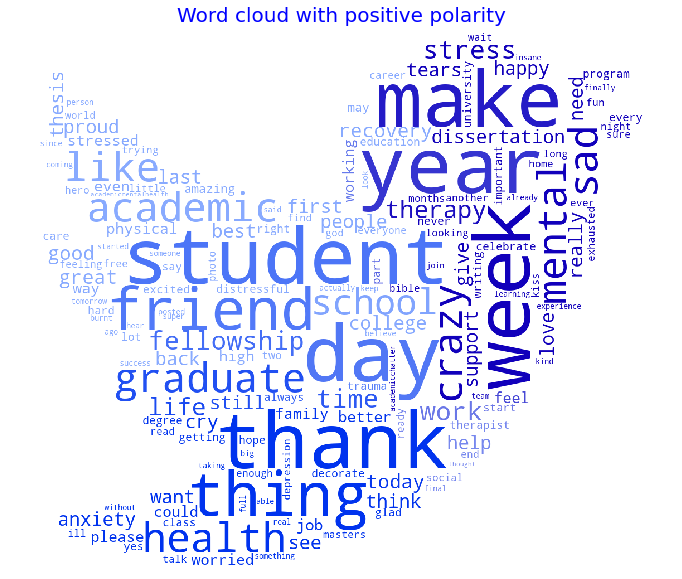

In [22]:
wordcloud = WordCloud(width=600, height=500, random_state=1, max_words=num_words, 
                          min_font_size=10,  max_font_size=140,
                          background_color='white',stopwords=set(STOPWORDS),mask = mask)
wordcloud.generate(str(" ".join(freq_words_p)))

image_colors = ImageColorGenerator(blue)
plt.figure(figsize=(20,10))
plt.title("Word cloud with positive polarity", fontsize=20,color='#0000FF')
plt.imshow(wordcloud, interpolation='bilinear')
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='None')
plt.axis('off')
plt.show()

In [23]:
wordcloud.to_file('twitter_positive_full.png')

In [42]:
freq_words_n = filter(lambda name: name.strip(), freq_words_n)

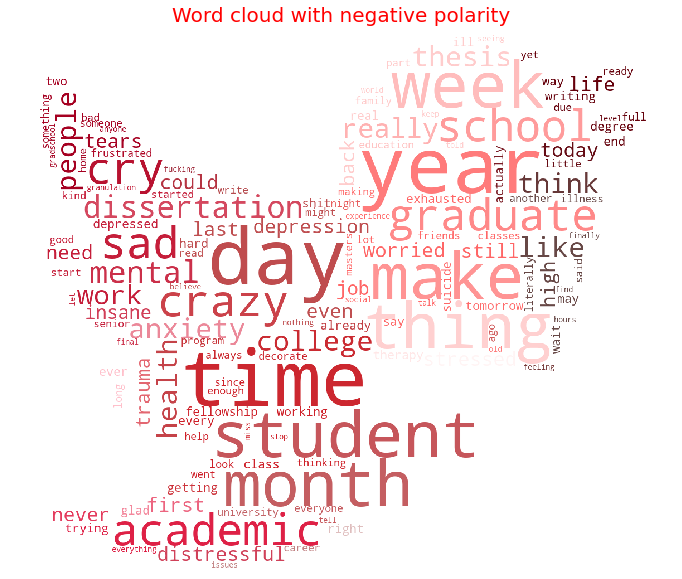

In [43]:
wordcloud = WordCloud(width=600, height=500, random_state=1, max_words=num_words, 
                          min_font_size=10,  max_font_size=140,
                          background_color='white',stopwords=set(STOPWORDS),mask = mask)
wordcloud.generate(str(" ".join(freq_words_n)))

image_colors = ImageColorGenerator(red)
plt.figure(figsize=(20,10))
plt.title("Word cloud with negative polarity", fontsize=20,color='red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='None')
plt.axis('off')
plt.show()

In [21]:
wordcloud.to_file('twitter_negative_full.png')

## N-grams (words correlation)

In [3]:
df = pd.read_csv('datasets/twitter_data_sent_full.csv',parse_dates=['created','date','year'])

In [52]:
def basic_clean(text):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatized after
  encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [53]:
words = basic_clean(''.join(str(df['text_nlp'].str.replace('pad','phd').tolist())))
stopwords = ['phdlife', 'phdchat', 'wearesun']
for word in list(words):  
    if word in stopwords:
       words.remove(word)

In [146]:
unigrams_series = (pd.Series(nltk.ngrams(words, 1)).value_counts())[:25]
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:25]
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:25]

Text(0.5, 0, 'Number of occurances')

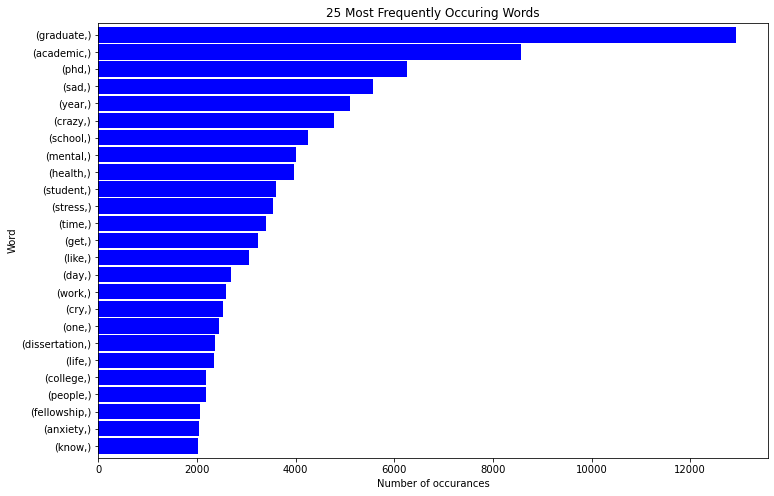

In [147]:
unigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('25 Most Frequently Occuring Words')
plt.ylabel('Word')
plt.xlabel('Number of occurances')

Text(0.5, 0, 'Number of occurances')

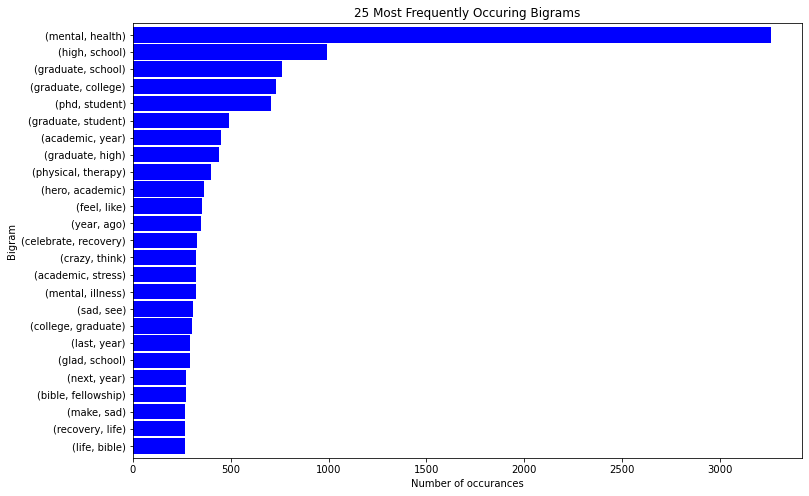

In [148]:
bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('25 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of occurances')

Text(0.5, 0, 'Number of occurances')

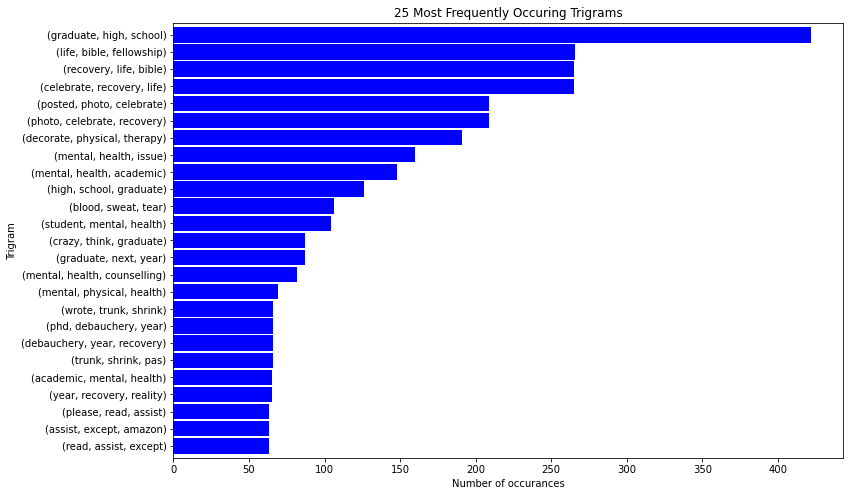

In [149]:
trigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('25 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('Number of occurances')

In [54]:
words_p = basic_clean(''.join(str(df.loc[df.sentiment == 'Positive']['text_nlp'].str.replace('anna','want').tolist())))
stopwords = ['phdlife', 'phdchat', 'wearesun']
for word in list(words_p):  
    if word in stopwords:
       words_p.remove(word)

In [45]:
unigrams_series_p = (pd.Series(nltk.ngrams(words_p, 1)).value_counts())[:25]
bigrams_series_p = (pd.Series(nltk.ngrams(words_p, 2)).value_counts())[:25]
trigrams_series_p = (pd.Series(nltk.ngrams(words_p, 3)).value_counts())[:25]

Text(0.5, 0, 'Number of occurances')

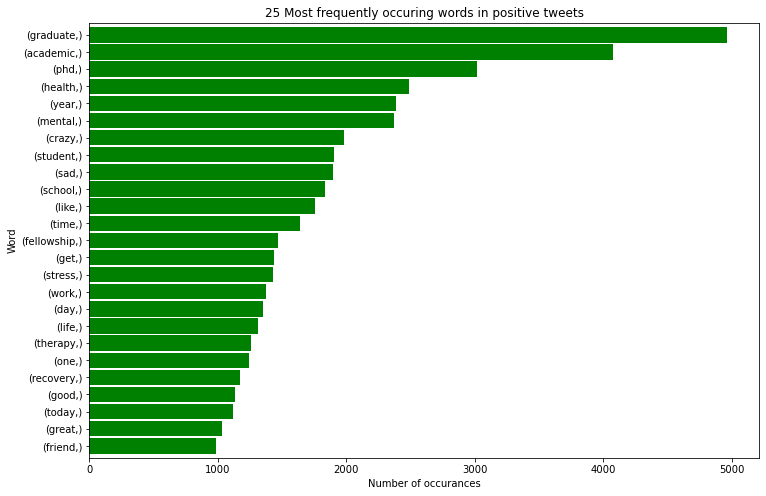

In [154]:
unigrams_series_p.sort_values().plot.barh(color='green', width=.9, figsize=(12, 8))
plt.title('25 Most frequently occuring words in positive tweets')
plt.ylabel('Word')
plt.xlabel('Number of occurances')

Text(0.5, 0, 'Number of occurances')

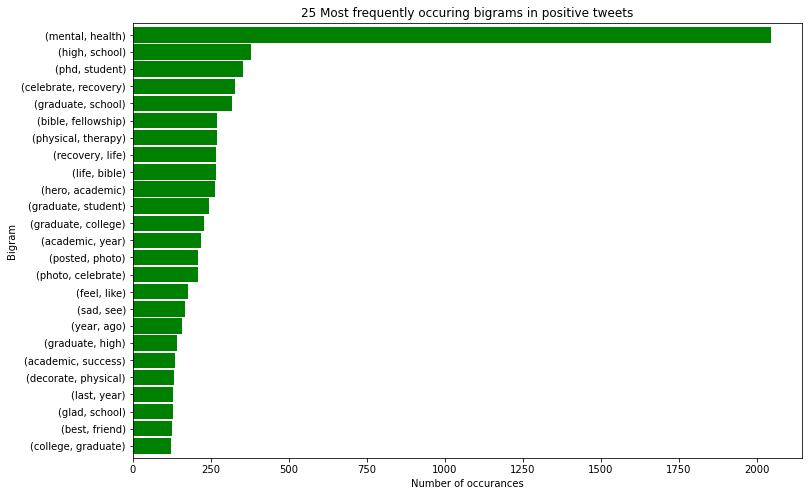

In [155]:
bigrams_series_p.sort_values().plot.barh(color='green', width=.9, figsize=(12, 8))
plt.title('25 Most frequently occuring bigrams in positive tweets')
plt.ylabel('Bigram')
plt.xlabel('Number of occurances')

Text(0.5, 0, 'Number of occurances')

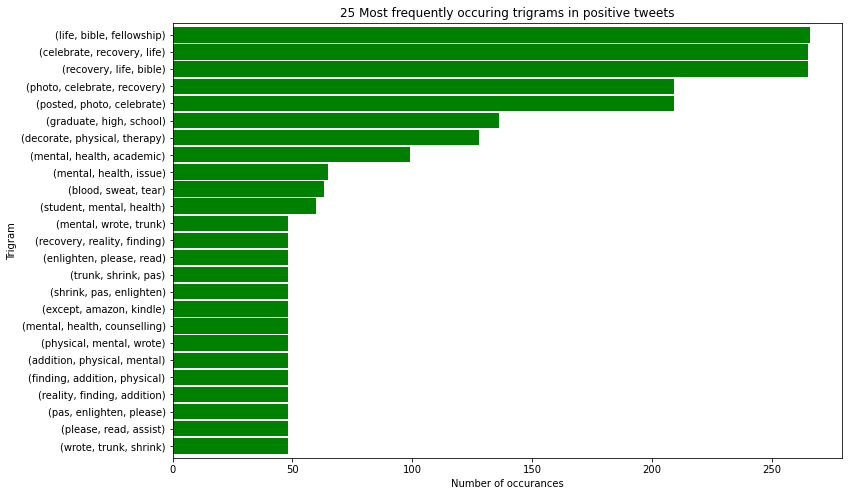

In [156]:
trigrams_series_p.sort_values().plot.barh(color='green', width=.9, figsize=(12, 8))
plt.title('25 Most frequently occuring trigrams in positive tweets')
plt.ylabel('Trigram')
plt.xlabel('Number of occurances')

In [55]:
words_n = basic_clean(''.join(str(df.loc[df.sentiment == 'Negative']['text_nlp'].str.replace('anna','want').tolist())))
stopwords = ['phdlife', 'phdchat', 'wearesun']
for word in list(words_n):  
    if word in stopwords:
       words_n.remove(word)

In [43]:
unigrams_series_n = (pd.Series(nltk.ngrams(words_n, 1)).value_counts())[:25]
bigrams_series_n = (pd.Series(nltk.ngrams(words_n, 2)).value_counts())[:25]
trigrams_series_n = (pd.Series(nltk.ngrams(words_n, 3)).value_counts())[:25]

Text(0.5, 0, 'Number of occurances')

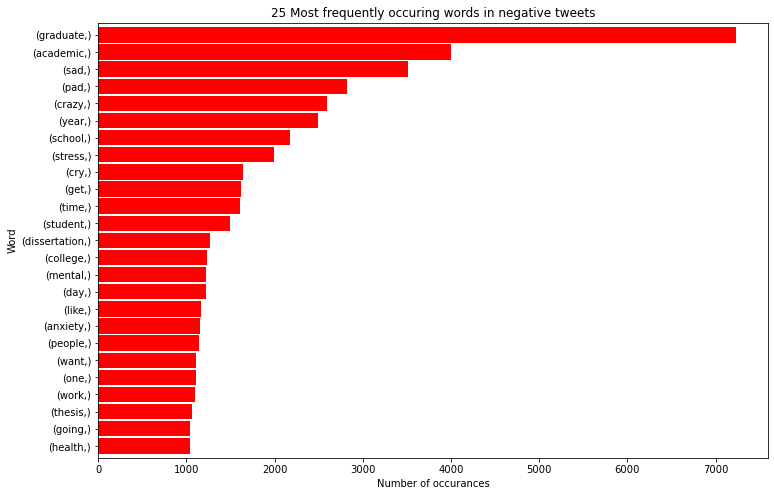

In [18]:
unigrams_series_n.sort_values().plot.barh(color='red', width=.9, figsize=(12, 8))
plt.title('25 Most frequently occuring words in negative tweets')
plt.ylabel('Word')
plt.xlabel('Number of occurances')

Text(0.5, 0, 'Number of occurances')

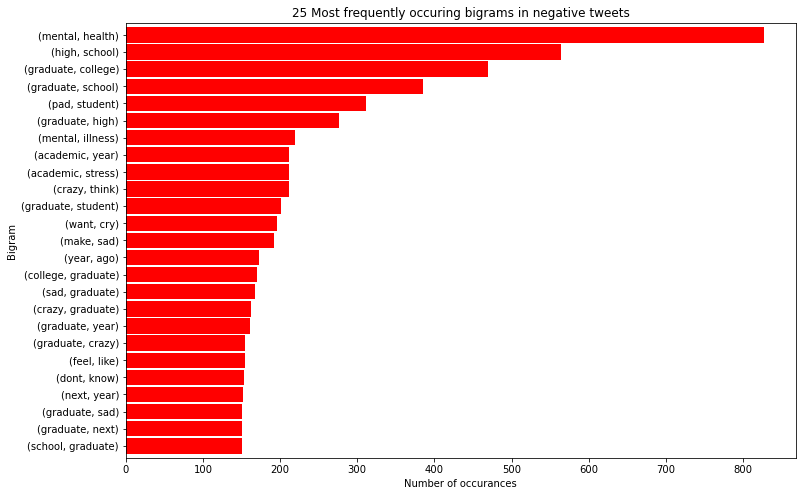

In [19]:
bigrams_series_n.sort_values().plot.barh(color='red', width=.9, figsize=(12, 8))
plt.title('25 Most frequently occuring bigrams in negative tweets')
plt.ylabel('Bigram')
plt.xlabel('Number of occurances')

Text(0.5, 0, 'Number of occurances')

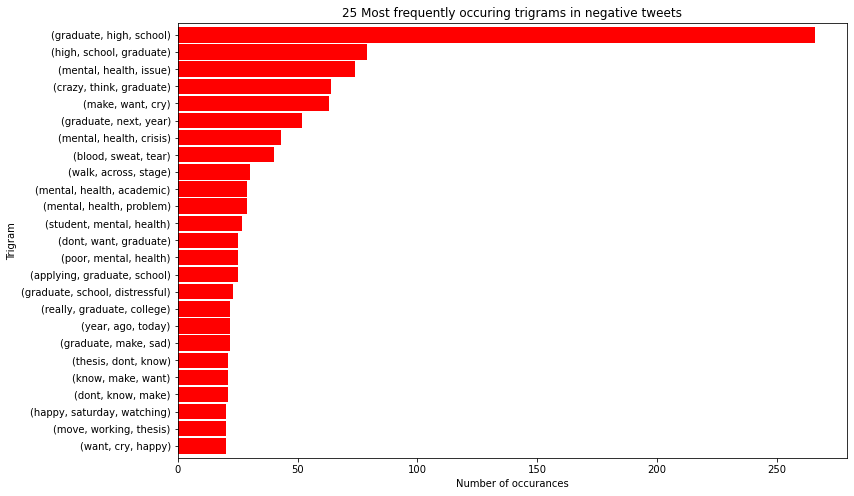

In [20]:
trigrams_series_n.sort_values().plot.barh(color='red', width=.9, figsize=(12, 8))
plt.title('25 Most frequently occuring trigrams in negative tweets')
plt.ylabel('Trigram')
plt.xlabel('Number of occurances')

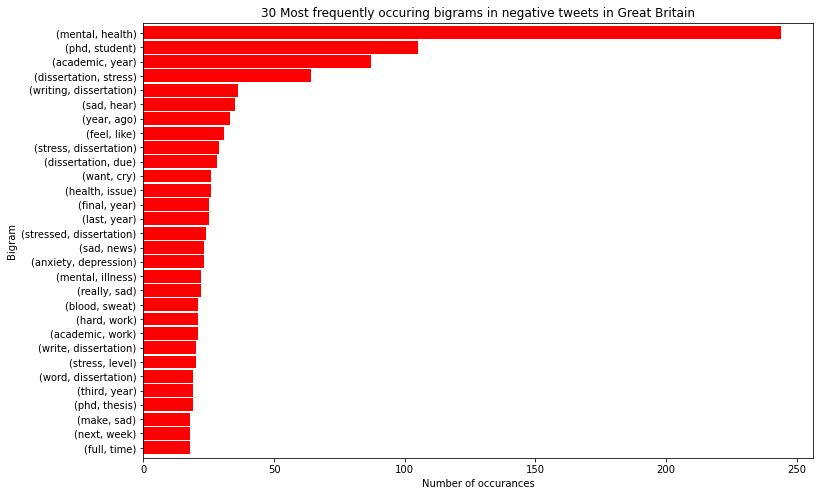

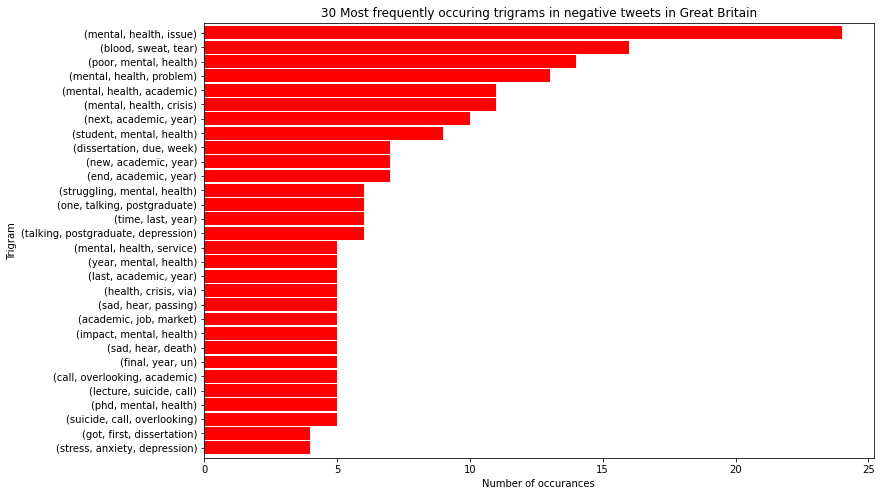

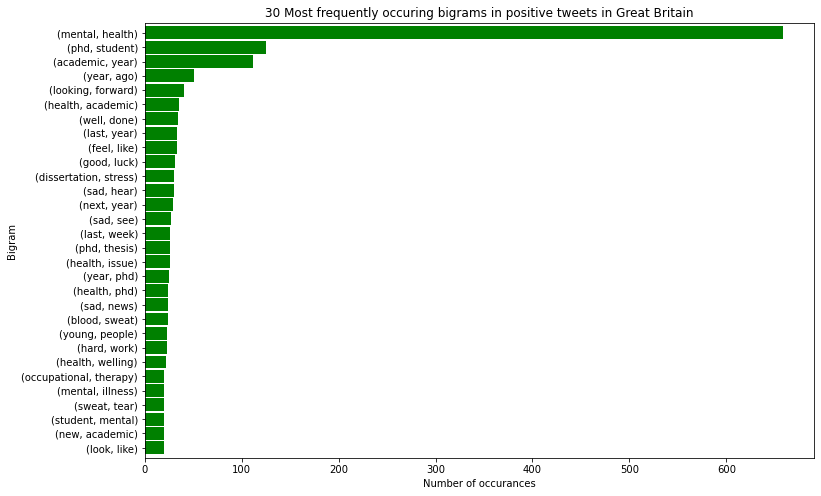

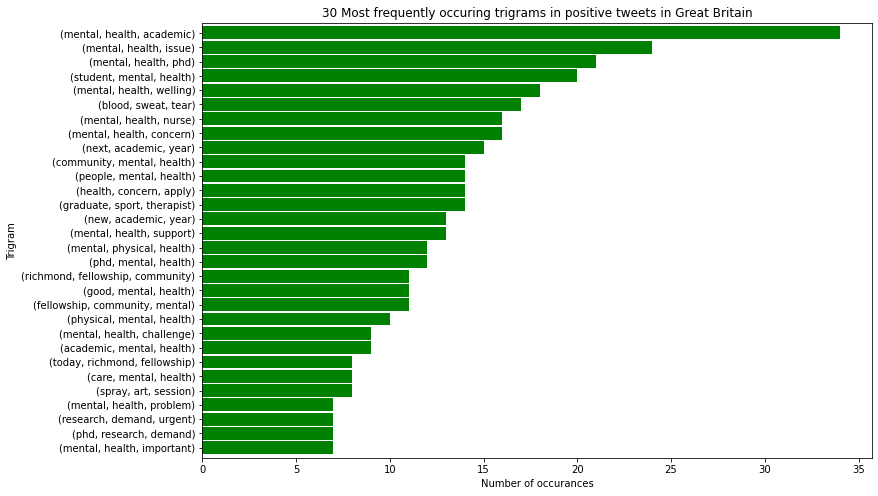

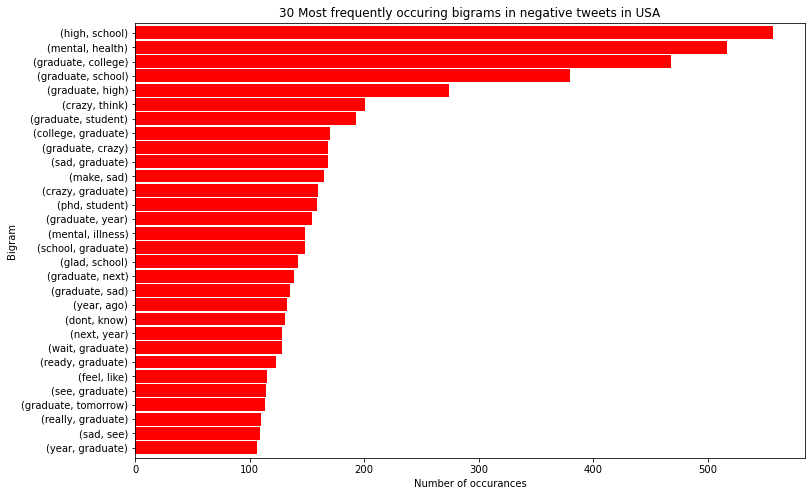

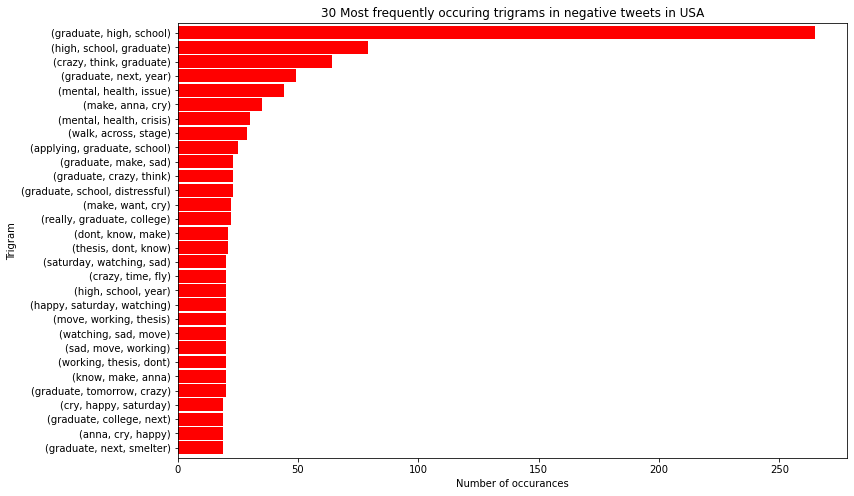

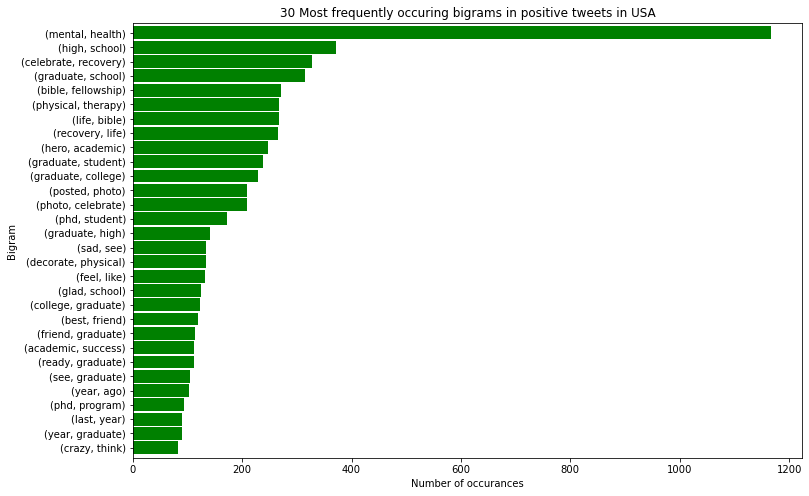

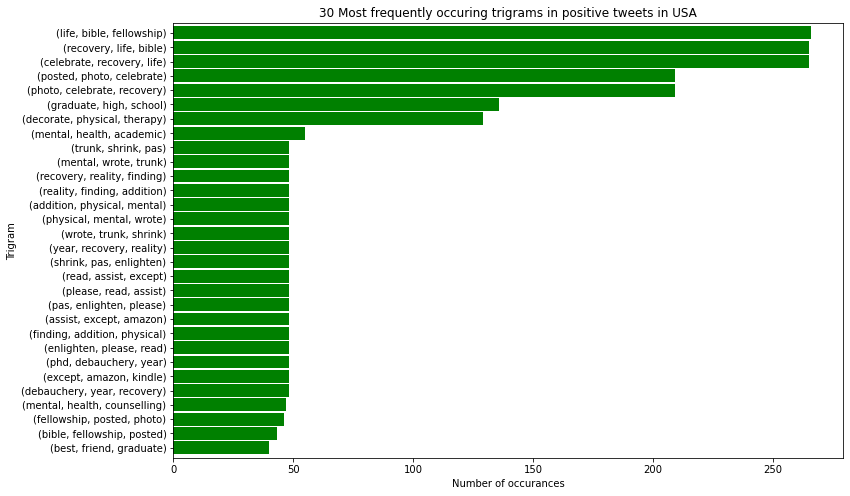

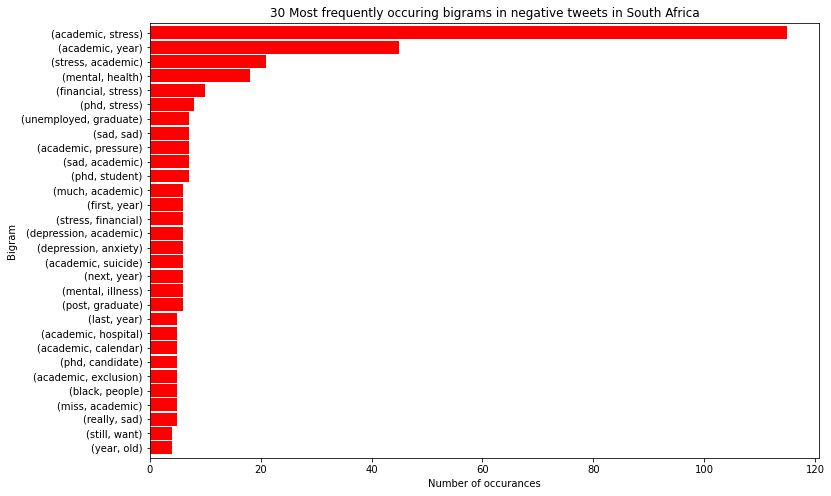

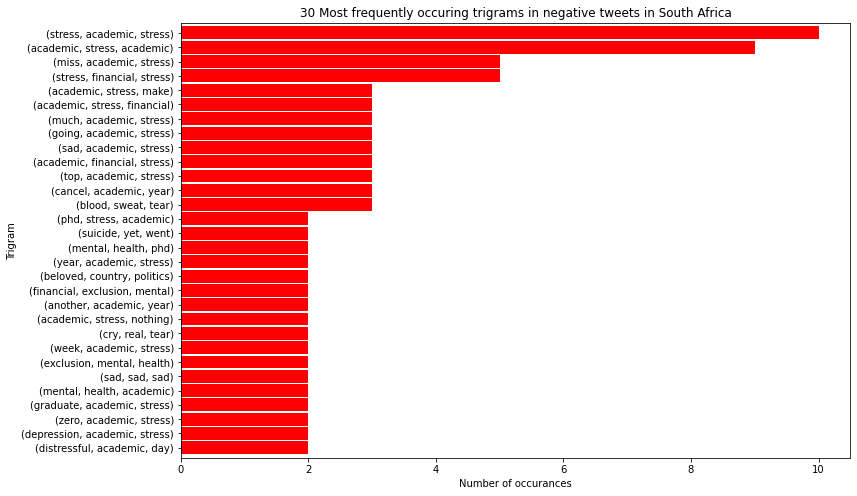

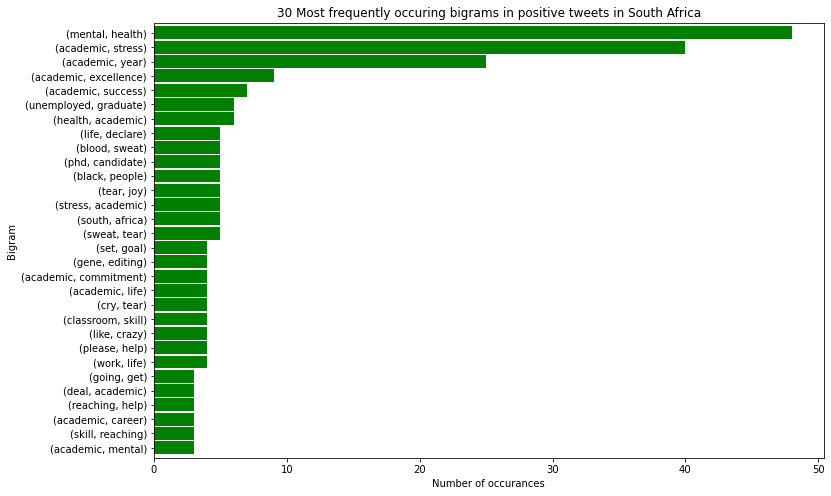

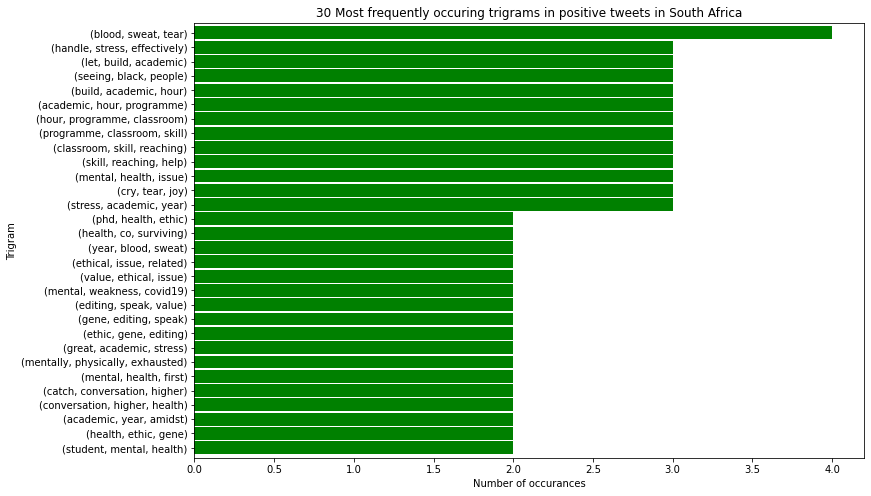

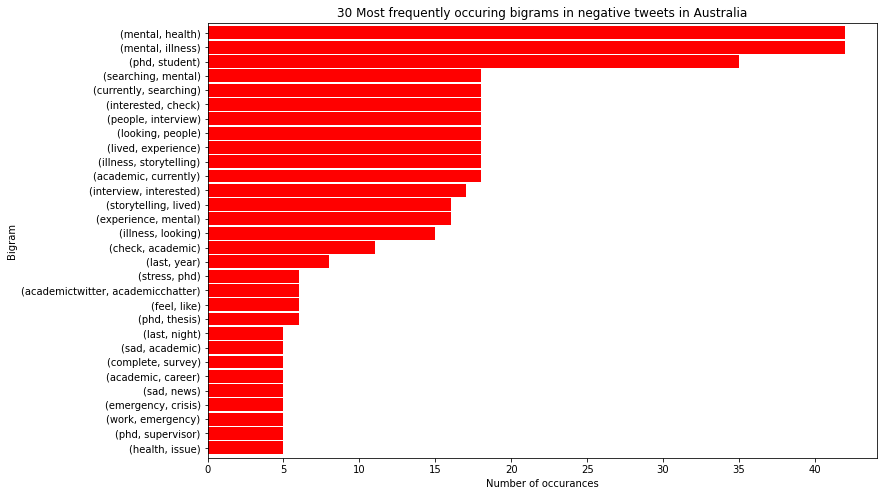

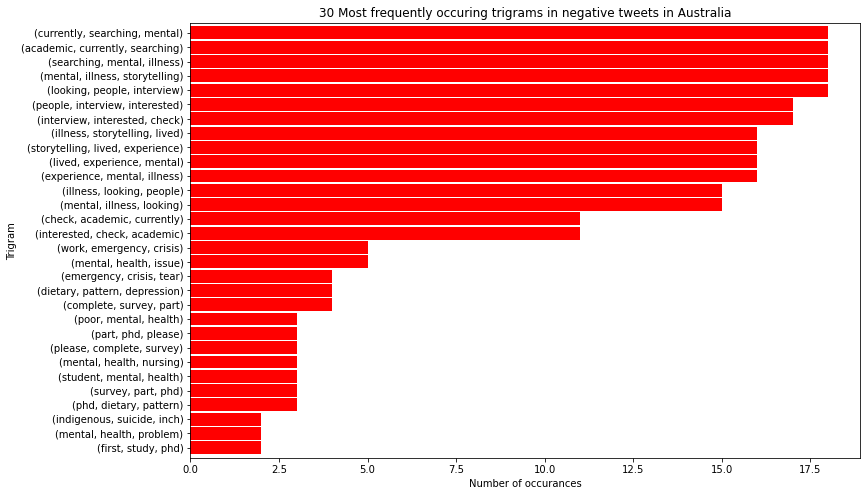

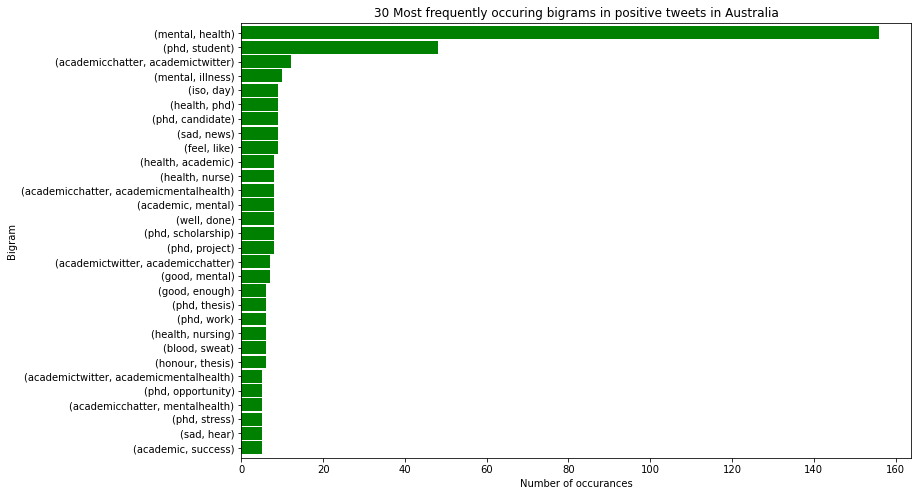

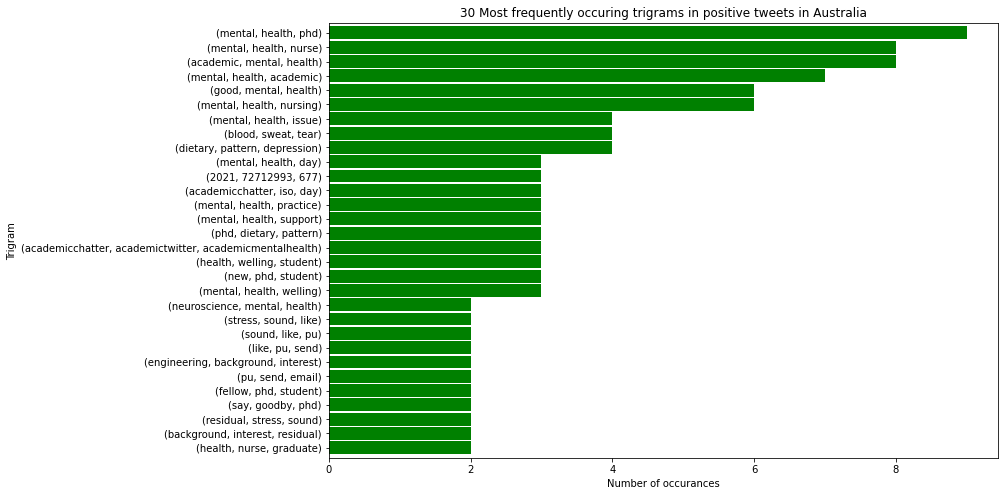

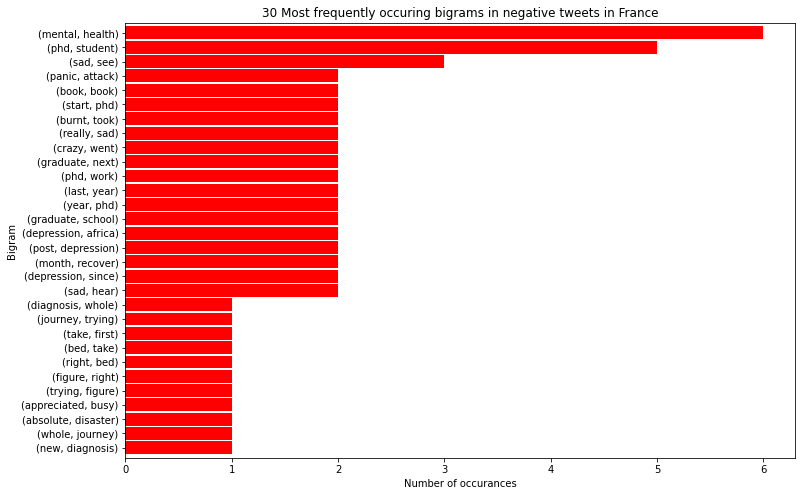

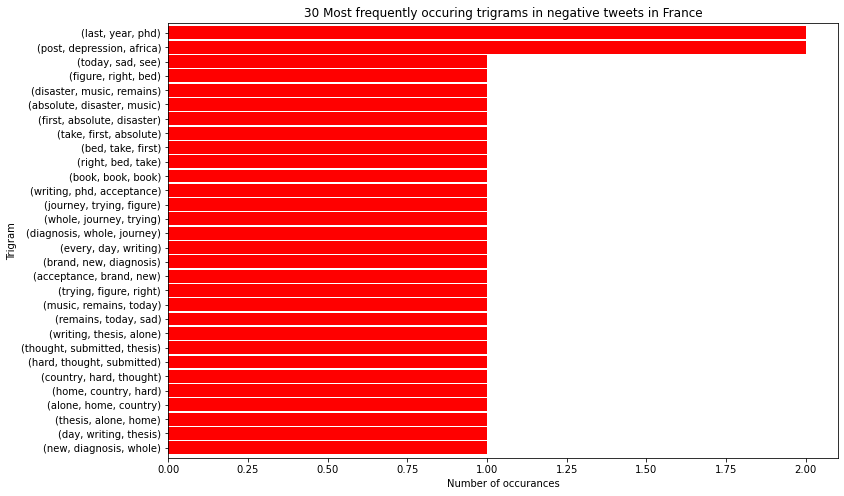

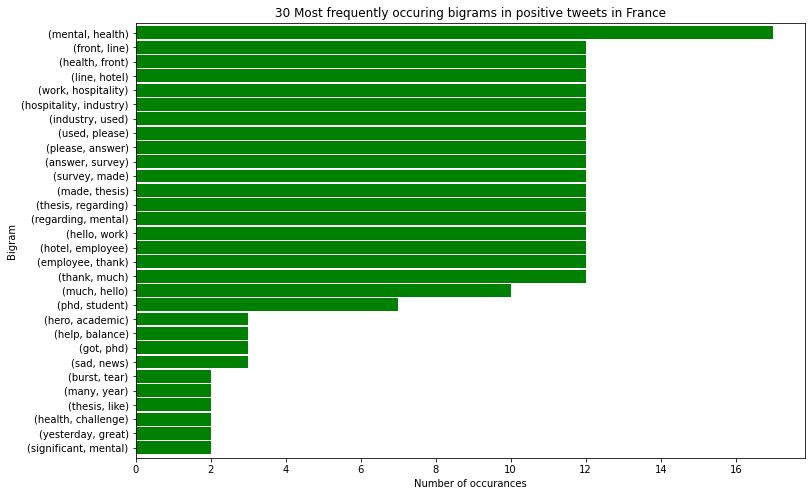

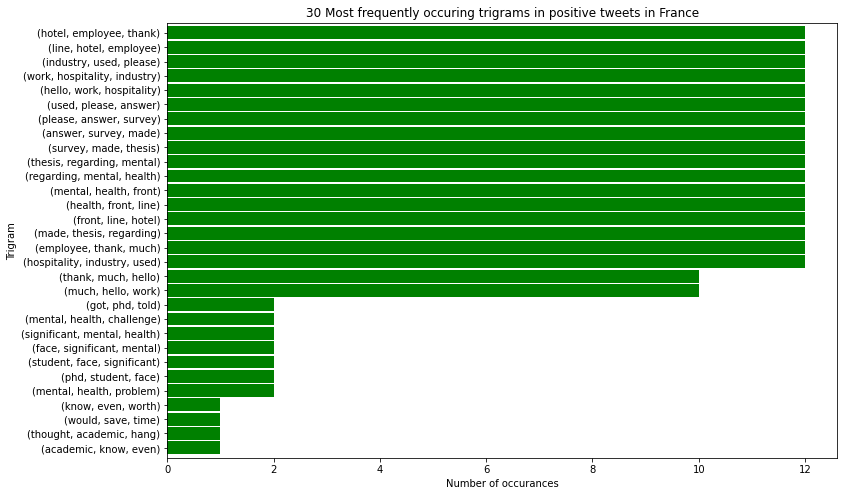

In [32]:
for country in df.country.unique():
    words_n = basic_clean(''.join(str(df.loc[(df.sentiment == 'Negative') & (df.country == country)]['text_nlp'].str.replace('pad','phd').tolist())))
    for word in list(words_n):  
        if word in stopwords:
            words_n.remove(word)

    bigrams_series_n = (pd.Series(nltk.ngrams(words_n, 2)).value_counts())[:30]
    trigrams_series_n = (pd.Series(nltk.ngrams(words_n, 3)).value_counts())[:30]
    
    words_p = basic_clean(''.join(str(df.loc[(df.sentiment == 'Positive') & (df.country == country)]['text_nlp'].str.replace('pad','phd').tolist())))
    for word in list(words_p):  
        if word in stopwords:
            words_p.remove(word)
    
    bigrams_series_p = (pd.Series(nltk.ngrams(words_p, 2)).value_counts())[:30]
    trigrams_series_p = (pd.Series(nltk.ngrams(words_p, 3)).value_counts())[:30]

    bigrams_series_n.sort_values().plot.barh(color='red', width=.9, figsize=(12, 8))
    plt.title(f'30 Most frequently occuring bigrams in negative tweets in {country}')
    plt.ylabel('Bigram')
    plt.xlabel('Number of occurances')
    plt.show()

    trigrams_series_n.sort_values().plot.barh(color='red', width=.9, figsize=(12, 8))
    plt.title(f'30 Most frequently occuring trigrams in negative tweets in {country}')
    plt.ylabel('Trigram')
    plt.xlabel('Number of occurances')
    plt.show()

    bigrams_series_p.sort_values().plot.barh(color='green', width=.9, figsize=(12, 8))
    plt.title(f'30 Most frequently occuring bigrams in positive tweets in {country}')
    plt.ylabel('Bigram')
    plt.xlabel('Number of occurances')
    plt.show()

    trigrams_series_p.sort_values().plot.barh(color='green', width=.9, figsize=(12, 8))
    plt.title(f'30 Most frequently occuring trigrams in positive tweets in {country}')
    plt.ylabel('Trigram')
    plt.xlabel('Number of occurances')
    plt.show()

In [56]:
stopwords = ['debauchery','anna']
for word in list(words_p):  
    if word in stopwords:
       words_p.remove(word)
for word in list(words_n):  
    if word in stopwords:
       words_n.remove(word)


In [57]:
# Create dictionary of bigrams and their counts
d = (pd.Series(nltk.ngrams(words_n, 3)).value_counts())[:50].to_frame(name='count').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

G.add_node("mental", weight=100)

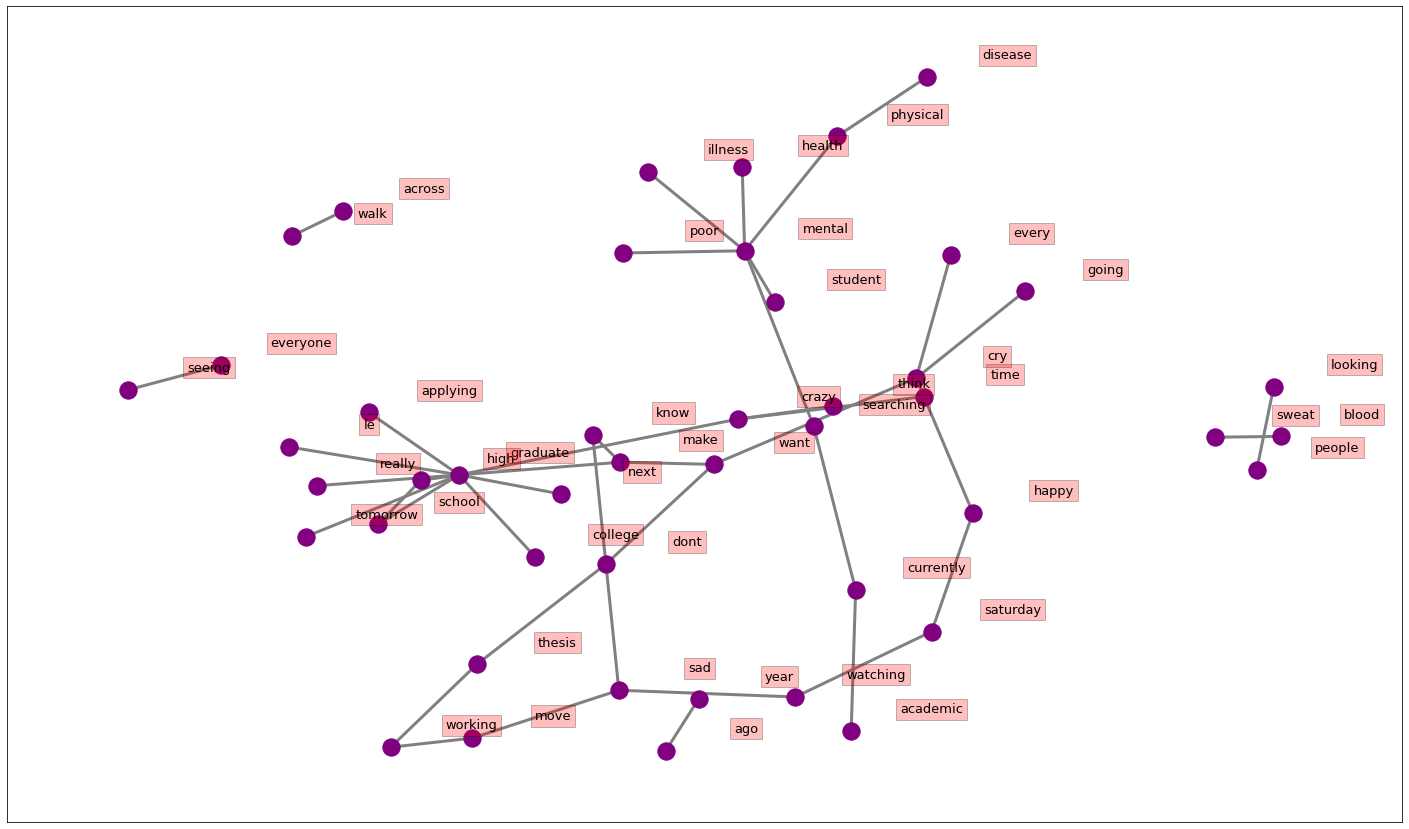

In [62]:
fig, ax = plt.subplots(figsize=(25, 15))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

In [49]:
# Create dictionary of bigrams and their counts
d = (pd.Series(nltk.ngrams(words_p, 3)).value_counts())[:50].to_frame(name='count').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

G.add_node("mental", weight=100)

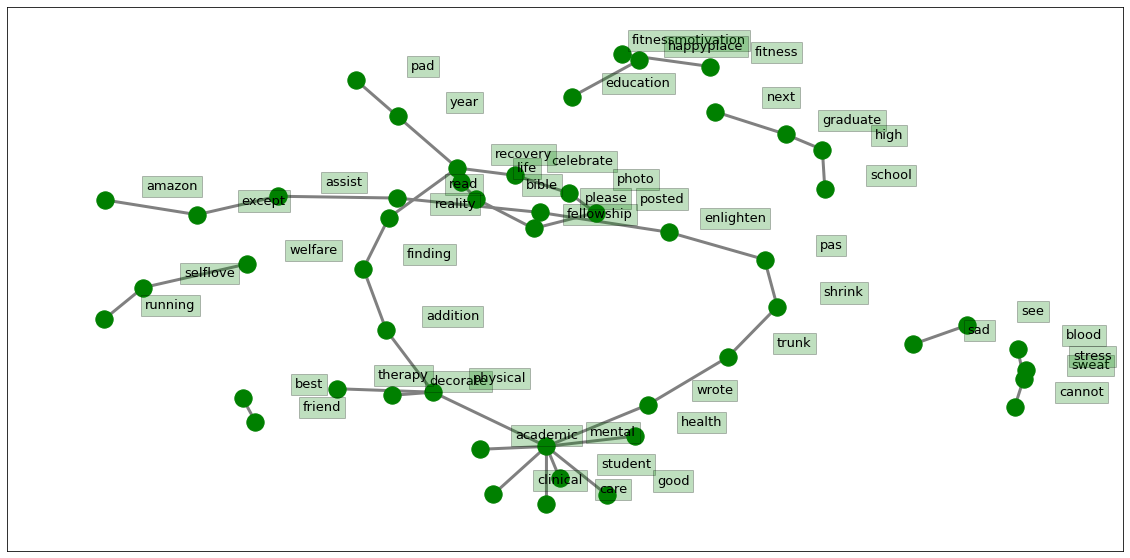

In [50]:
fig, ax = plt.subplots(figsize=(20, 10))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='green',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='green', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## Supervision topic

In [25]:
print(f"There are about {len(df[df['text'].str.contains('supervision|supervisor|tutor|curator|boss|guidance|director|directrice|professor|advisor')])} tweets mentionning supervision.")

There are about 1027 tweets mentionning supervision.


In [27]:
pd.set_option('max_colwidth',800)
data = df[df['text'].str.contains('supervision|supervisor|tutor|curator|boss|guidance|director|directrice|professor|advisor')]
data['text'].sample(10)

30996                                                                                                            Lmaaaoooo my academic advisor didn’t let me drop a class because she said she knew I could do it and that I’m just stressed. SIS I DIDNT ASK FOR ENCOURAGEMENT I asked for you to drop my mf class 😭😭😭😭
15990                                                  When I've voiced my concerns about being financially stable through my PhD:\n\n"Your boyfriend will support you through your PhD."\n\nand \n\n"If you're worried about money, do your PhD in two years. My supervisor was able to do it." https://t.co/WpiWZnW1ep
19840                                                                                                                                           After I graduate beauty school let’s just say. I’ll be doing movie stars hair. I have connections already up in Hollywood and also movie  directors. So no stress there.
7834                                                         

In [28]:
data1 = data.groupby(['sentiment']).text_nlp.count().to_frame().reset_index()
fig = px.pie(data1, values='text_nlp', names='sentiment', template='plotly_white', width=600, color_discrete_sequence=["lightgreen", "salmon","grey"])
fig.update_layout(title_text='Sentiment polarity', title_x=0.5)
fig.show()

In [29]:
# polarity of tweets by country
data1 = data.groupby(['country'])['compound'].mean().to_frame().reset_index()
data1['compound'] = round(data1['compound'],2)

fig = px.bar(data1.sort_values(by='compound'), x='country', y='compound', color='country', width=600, height=500, template='plotly_white', color_discrete_sequence=px.colors.qualitative.Pastel2, 
            title='Average polarity of tweets about supervision by country', labels={'compound':'average polarity'}, text_auto=True)
fig.show()

In [30]:
data1 = data.groupby(['year']).mean()['compound'].to_frame().reset_index()

fig = px.line(data1, x="year", y="compound", width=800, height=500,
             title='Average polarity of tweets about supervision by year',template='plotly_white', labels={'compound':'average sentiment polarity'})
fig.show()

In [18]:
# covid influence - polarity of tweets by period
data1 = data.groupby(['covid'])['compound'].mean().to_frame().reset_index()
data1['compound'] = round(data1['compound'],2)

fig = px.bar(data1.sort_values(by='compound'), x='covid', y='compound', color='compound', width=600, height=500, template='plotly_white', color_continuous_scale='blues', 
            title='Average polarity of tweets about supervision by period of covid', labels={'compound':'average polarity'}, text_auto=True)
fig.show()

In [31]:
# covid influence - polarity of tweets by period
data1 = data.groupby(['covid','country'])['compound'].mean().to_frame().reset_index()
data1['compound'] = round(data1['compound'],2)

fig = px.bar(data1.sort_values(by='compound'), x='covid', y='compound', color='country', width=1000, height=1000, template='plotly_white', color_discrete_sequence=px.colors.qualitative.Pastel2,
            title='Average polarity of tweets by period of covid', labels={'compound':'average polarity'}, text_auto=True, opacity=0.8,facet_col='country', facet_col_wrap=2)
fig.show()

In [47]:
def basic_clean(text):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatized after
  encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

words = basic_clean(''.join(str(data['text_nlp'].str.replace('pad','phd').tolist())))
stopwords = ['phdlife', 'phdchat', 'wearesun','etc','got','2017','st','advisor','academic','professor','supervisor','phd','student','adviser','director']
for word in list(words):  
    if word in stopwords:
       words.remove(word)

unigrams_series = (pd.Series(nltk.ngrams(words, 1)).value_counts())[:30]
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:30]
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:30]

Text(0.5, 0, 'Number of occurances')

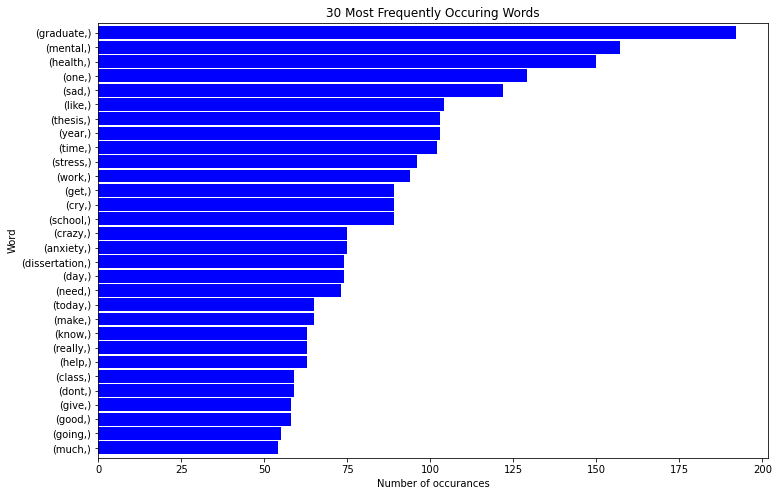

In [48]:
unigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('30 Most Frequently Occuring Words')
plt.ylabel('Word')
plt.xlabel('Number of occurances')

Text(0.5, 0, 'Number of occurances')

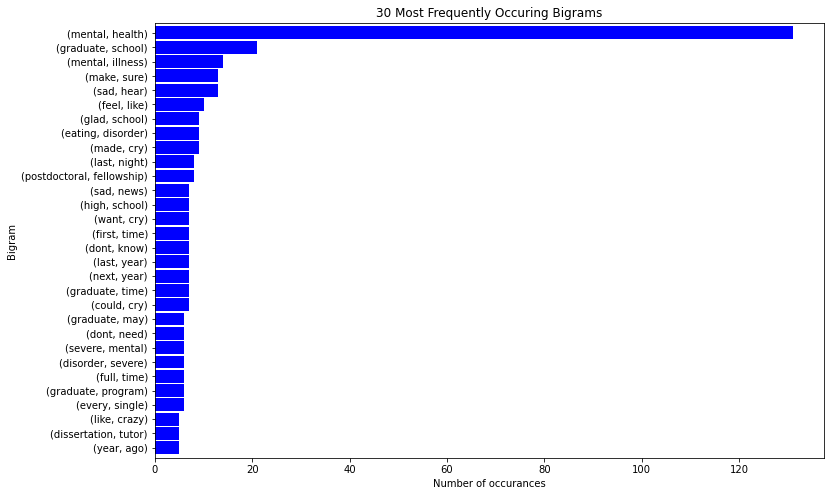

In [49]:
bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('30 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of occurances')

Text(0.5, 0, 'Number of occurances')

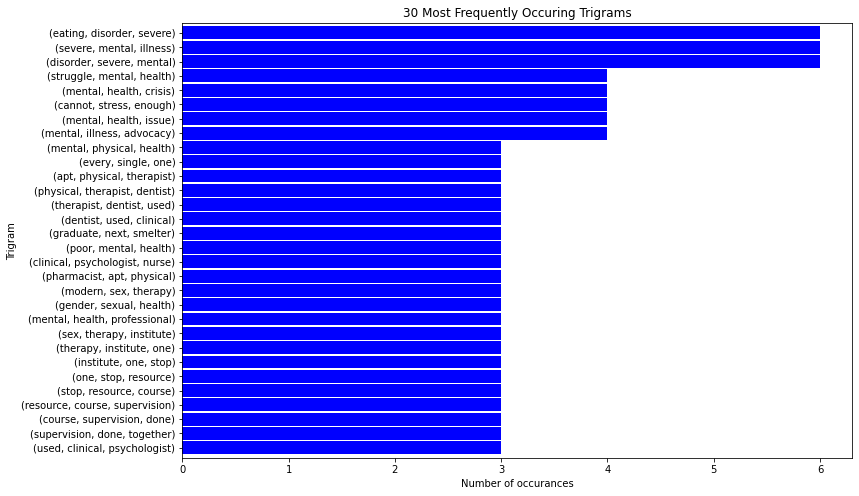

In [50]:
trigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('30 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('Number of occurances')

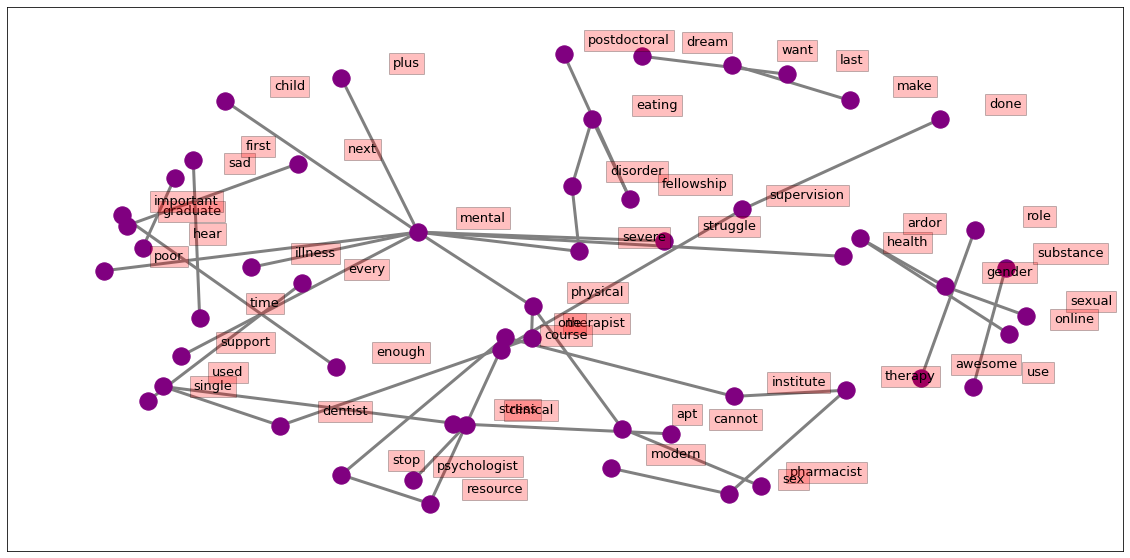

In [51]:
# Create dictionary of bigrams and their counts
d = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:50].to_frame(name='count').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

G.add_node("mental", weight=100)

fig, ax = plt.subplots(figsize=(20, 10))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

In [97]:
data[data.sentiment == 'Negative']['text'].sample(10)

5760                                                          If anyone saw my tweet about mental health in academia yesterday and thought I was talking about my personal situation, I NEED to clarify! I have had the best PhD supervisors and would hate for anyone to think otherwise. However there are others not so lucky.
24263                                                                            i’ve decided that “academic trauma” is a valid thing that i have experienced. mostly from unorganized or incompetent professors but also from profs who give 90 question MC exams to grad students over 17 chapters and 7 movies and 7 lectures.
19545                                              So...my thesis advisor is unhappy for not making satisfactory progress this summer with my thesis. Pretty much failed her expectations. Being pushed from all directions doesn’t help me out. I got depressed, so my concentration was down the drain. https://t.co/qpoDby1SgC
6665                              

In [95]:
data[data.sentiment == 'Positive']['text'].sample(10)

6441                                                                                                                                                                                                                                                                                                                                                                                                                                                                        @DrBurkeHarris I’m a 3rd year doctoral student doing my dissertation on resilience. I’m looking into a toxic stress perspective. I would love some guidance.  Love your book.
35222                                                                                                                                                                                                                                                                                                                                                                         

In [78]:
# creating word frequency count
data['text_nlp']=data['text_nlp'].fillna("")
num_words = 200
word2count_p = {}
word2count_n = {}
for i in tqdm(range(len(data.loc[data.sentiment == 'Positive']['text_nlp']))): 
    for word in data.loc[df.sentiment == 'Positive']['text_nlp'].iloc[i].split():
        if word not in word2count_p.keys(): 
            word2count_p[word] = 1
        else: 
            word2count_p[word] += 1

for i in tqdm(range(len(data.loc[data.sentiment == 'Negative']['text_nlp']))): 
    for word in data.loc[data.sentiment == 'Negative']['text_nlp'].iloc[i].split():
        if word not in word2count_n.keys(): 
            word2count_n[word] = 1
        else: 
            word2count_n[word] += 1
            
freq_words_p = heapq.nlargest(num_words, word2count_p, key=word2count_p.get)
freq_words_n = heapq.nlargest(num_words, word2count_n, key=word2count_n.get)

stopwords = ['iäôve','done','well','its','pad','made','much','take','phdlife','got','know','next','going','new','quite','get', 'far', 'smelter',
            'many','also','dont','phdchat','would','un', 'one','via','youäôre','donna','took','whole','come','academictwitter','mentalhealth']
for word in list(freq_words_p):  
    if word in stopwords:
        freq_words_p.remove(word)
for word in list(freq_words_n):  
    if word in stopwords:
        freq_words_n.remove(word)

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_86782/3741944828.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 441/441 [00:00<00:00, 2535.40it/s]


In [79]:
# present only in positive
list(set(freq_words_p) - set(freq_words_n))

['thought',
 'please',
 'pretty',
 'enough',
 'better',
 'll',
 'office',
 'recovery',
 'senators',
 'thank',
 'positive',
 'love',
 'god',
 'clinical',
 'psychiatric',
 'huge',
 'ago',
 'role',
 'ill',
 'important',
 'team',
 'tutor',
 'success',
 'postdoc',
 'grateful',
 'tutors',
 'things',
 'exam',
 'therapist',
 'happy',
 'wonderful',
 'worked',
 'lab',
 'gave',
 'schedule',
 'proud',
 'everything',
 'believe',
 'every',
 'care',
 'guidance',
 'physical',
 'disorders',
 'journey',
 'she',
 'become',
 'two',
 'ever',
 'family',
 'night',
 'suppurative',
 'best',
 'worth',
 'nice',
 'friends',
 'able',
 'training',
 'something',
 'excited',
 'amazing',
 'taking',
 'read',
 'awesome',
 'professional',
 'finally',
 'join',
 'burnt',
 'hope',
 'friend',
 'part',
 'thanks']

In [80]:
# present only in negative
list(set(freq_words_n) - set(freq_words_p))

['drop',
 'cause',
 'trying',
 'anyone',
 'education',
 'mon',
 'frustrated',
 'started',
 'hear',
 'major',
 'shit',
 'insane',
 'went',
 'wrong',
 'fucking',
 'stop',
 'decorate',
 'depression',
 'early',
 'hell',
 'sent',
 'talk',
 'summer',
 'suicide',
 'ask',
 'reading',
 'passed',
 'higher',
 'write',
 'left',
 'state',
 'anna',
 'long',
 'real',
 'resources',
 'process',
 'hate',
 'eating',
 'masters',
 'someone',
 'meeting',
 'all',
 'less',
 'case',
 'illness',
 'look',
 'asked',
 'deadline',
 'especially',
 'tried',
 'bad',
 'found',
 'grade',
 'end',
 'already',
 'instead',
 'system',
 'away',
 'project',
 'depressed',
 'leave',
 'cried',
 'asking',
 'hard',
 'knew',
 'damn',
 'makes',
 'keep',
 'either',
 'call',
 'stupid']

In [81]:
def common_member(a, b):
    a_set = set(a)
    b_set = set(b)
 
    if (a_set & b_set):
        print(a_set & b_set)
    else:
        print("No common elements")
common_member(freq_words_n, freq_words_p)

{'start', 'talking', 'anxiety', 'help', 'years', 'degree', 'writing', 'tell', 'supervisor', 'stressed', 'trauma', 'say', 'need', 'even', 'life', 'see', 'class', 'time', 'advisers', 'sure', 'glad', 'like', 'told', 'health', 'experience', 'final', 'world', 'sad', 'still', 'your', 'always', 'stress', 'lot', 'little', 'college', 'could', 'making', 'student', 'feeling', 'distressful', 'great', 'due', 'want', 'never', 'good', 'professor', 'people', 'everyone', 'didn', 'students', 'days', 'right', 'back', 'make', 'worried', 'email', 'program', 'actually', 'graduate', 'mental', 'last', 'feel', 'supervisors', 'dissertation', 'way', 'crazy', 'career', 'cry', 'working', 'boss', 'yes', 'give', 'support', 'hours', 'year', 'school', 'professors', 'months', 'said', 'week', 'supervision', 'first', 'high', 'can', 'thing', 'full', 'kind', 'director', 'thesis', 'university', 'today', 'academic', 'another', 'day', 'therapy', 'think', 'getting', 'may', 'fellowship', 'work', 'job', 'tears', 'nothing', 'advi

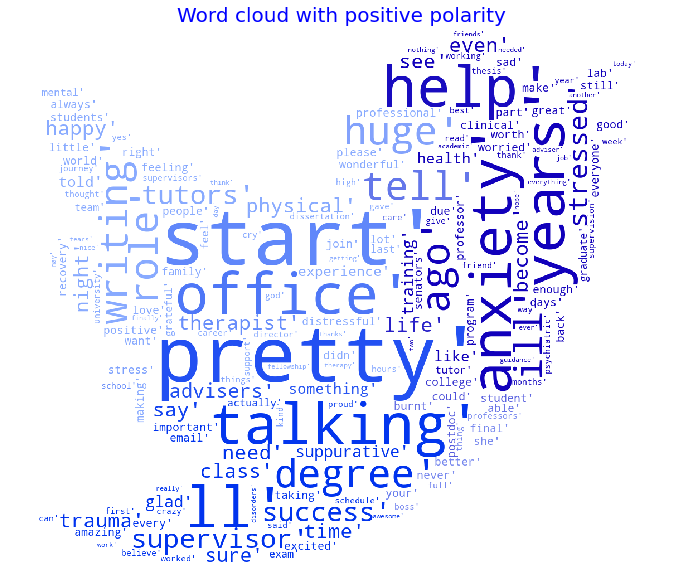

In [82]:
wordcloud = WordCloud(width=600, height=500, random_state=1, max_words=num_words, 
                          min_font_size=10,  max_font_size=140,
                          background_color='white',stopwords=set(STOPWORDS),mask = mask)
wordcloud.generate(str(set(freq_words_p)))

image_colors = ImageColorGenerator(blue)
plt.figure(figsize=(20,10))
plt.title("Word cloud with positive polarity", fontsize=20,color='#0000FF')
plt.imshow(wordcloud, interpolation='bilinear')
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='None')
plt.axis('off')
plt.show()

In [83]:
#wordcloud.to_file('pictures/twitter_support_full.png')

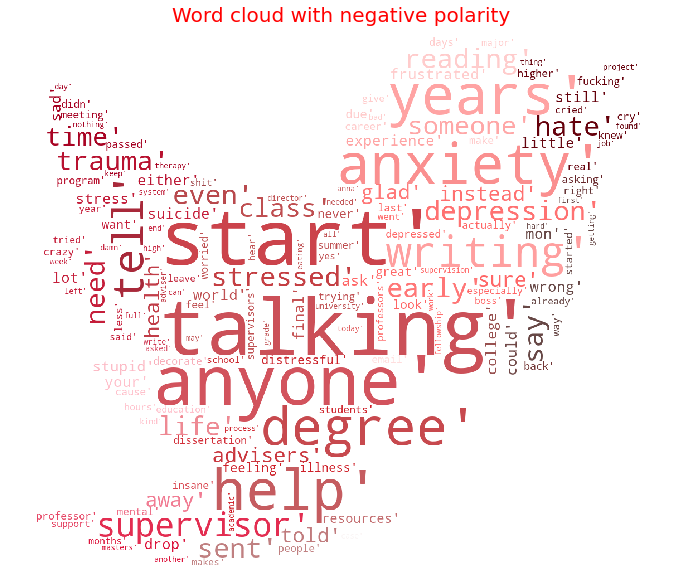

In [84]:
wordcloud = WordCloud(width=600, height=500, random_state=1, max_words=num_words, 
                          min_font_size=10,  max_font_size=140,
                          background_color='white',stopwords=set(STOPWORDS),mask = mask)
wordcloud.generate(str(set(freq_words_n)))

image_colors = ImageColorGenerator(red)
plt.figure(figsize=(20,10))
plt.title("Word cloud with negative polarity", fontsize=20,color='red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='None')
plt.axis('off')
plt.show()

In [85]:
#wordcloud.to_file('pictures/twitter_support_full_neg.png')

## Support topic

In [32]:
print(f"There are about {len(df[df['text'].str.contains('support|supportive|supported|aid|assist|help|assistance|encourage')])} tweets mentionning support.")

There are about 3350 tweets mentionning support.


In [33]:
data = df[df['text'].str.contains('support|supportive|supported|aid|assist|help|assistance|encourage')]
data['text'].sample(10)

23154                      https://t.co/AFJUHh1eVN\n\nHey guys I’m posting this again!!! Anything helps please help his dreams come true and relieve him some stress and body dysphoria The goal is to try &amp; raise enough money  to get surgerythey graduate hs next year in June! Please #rp #FTM #TransIsBeautiful
19540                                                                                                    Y’all thought this was over...? Nah you’re girl just got accepted in to graduate school that comes fully paid for. You don’t know the tears I’ve cried, the prayers I’ve said, and the… https://t.co/kZi6v1Pl1L
20325           @sofia_akel @showroomcinema @ANetWoC @Muna_Abdi_Phd @28jacs @Mister_deen24 @desreereynolds @FrancesAnne Sad. Feel free to share. We need these narratives to become mainstream. Also a good opportunity to support the sisters of colour or directed and produced this show. Let’s go all Wakanda on it!
36445    I am elated to announce that I will be pursuing my P

In [34]:
data1 = data.groupby(['sentiment']).text_nlp.count().to_frame().reset_index()
fig = px.pie(data1, values='text_nlp', names='sentiment', template='plotly_white', width=600, color_discrete_sequence=["lightgreen", "salmon","grey"])
fig.update_layout(title_text='Sentiment polarity', title_x=0.5)
fig.show()

In [35]:
# polarity of tweets by country
data1 = data.groupby(['country'])['compound'].mean().to_frame().reset_index()
data1['compound'] = round(data1['compound'],2)

fig = px.bar(data1.sort_values(by='compound'), x='country', y='compound', color='country', width=600, height=500, template='plotly_white', color_discrete_sequence=px.colors.qualitative.Pastel2, 
            title='Average polarity of tweets about supervision by country', labels={'compound':'average polarity'}, text_auto=True)
fig.show()

In [36]:
data1 = data.groupby(['year']).mean()['compound'].to_frame().reset_index()

fig = px.line(data1, x="year", y="compound", width=800, height=500, 
             title='Average polarity of tweets by year',template='plotly_white', labels={'compound':'average sentiment polarity'})
fig.show()

In [58]:
# covid influence - polarity of tweets by period
data1 = data.groupby(['covid'])['compound'].mean().to_frame().reset_index()
data1['compound'] = round(data1['compound'],2)

fig = px.bar(data1.sort_values(by='compound'), x='covid', y='compound', color='compound', width=600, height=500, template='plotly_white', color_continuous_scale='blues', 
            title='Average polarity of tweets about supervision by period of covid', labels={'compound':'average polarity'}, text_auto=True)
fig.show()

In [37]:
# covid influence - polarity of tweets by period
data1 = data.groupby(['covid','country'])['compound'].mean().to_frame().reset_index()
data1['compound'] = round(data1['compound'],2)

fig = px.bar(data1.sort_values(by='compound'), x='covid', y='compound', color='country', width=1000, height=1000, template='plotly_white', color_discrete_sequence=px.colors.qualitative.Pastel2,
            title='Average polarity of tweets by period of covid', labels={'compound':'average polarity'}, text_auto=True, opacity=0.8,facet_col='country', facet_col_wrap=2)
fig.show()

In [60]:
def basic_clean(text):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatized after
  encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

words = basic_clean(''.join(str(data['text_nlp'].str.replace('pad','phd').tolist())))
stopwords = ['phdlife', 'phdchat', 'wearesun','etc','got','2017','st','advisor','academic','professor','supervisor','phd','student','adviser','director']
for word in list(words):  
    if word in stopwords:
       words.remove(word)

unigrams_series = (pd.Series(nltk.ngrams(words, 1)).value_counts())[:30]
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:30]
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:30]

Text(0.5, 0, 'Number of occurances')

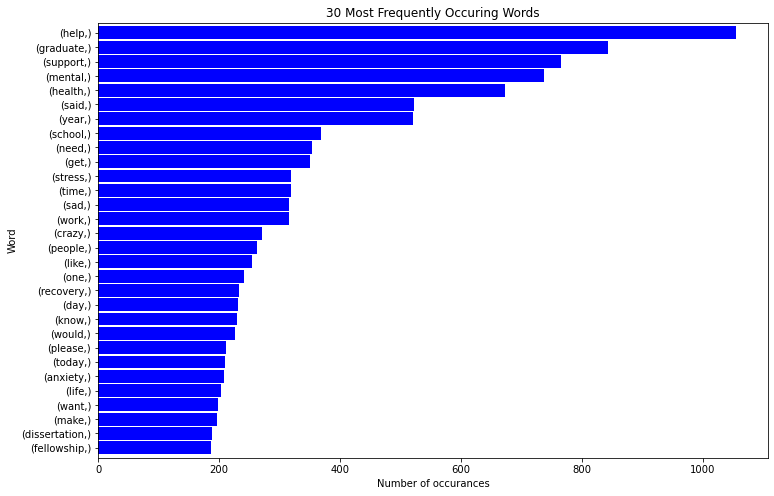

In [61]:
unigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('30 Most Frequently Occuring Words')
plt.ylabel('Word')
plt.xlabel('Number of occurances')

Text(0.5, 0, 'Number of occurances')

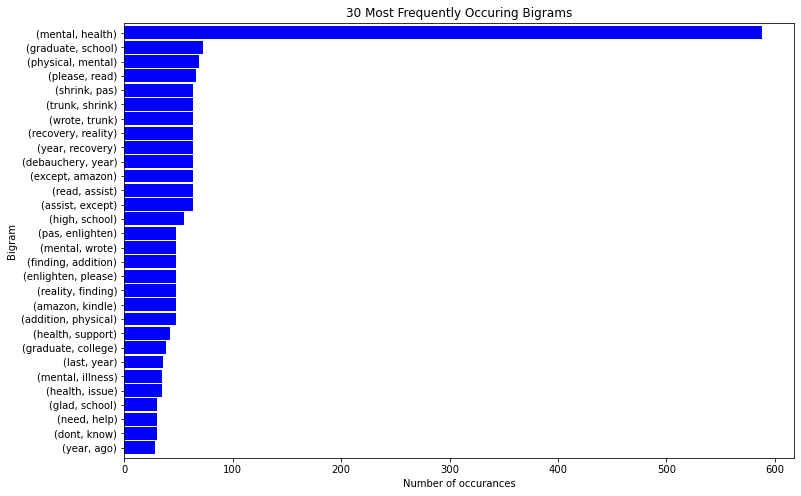

In [62]:
bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('30 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of occurances')

Text(0.5, 0, 'Number of occurances')

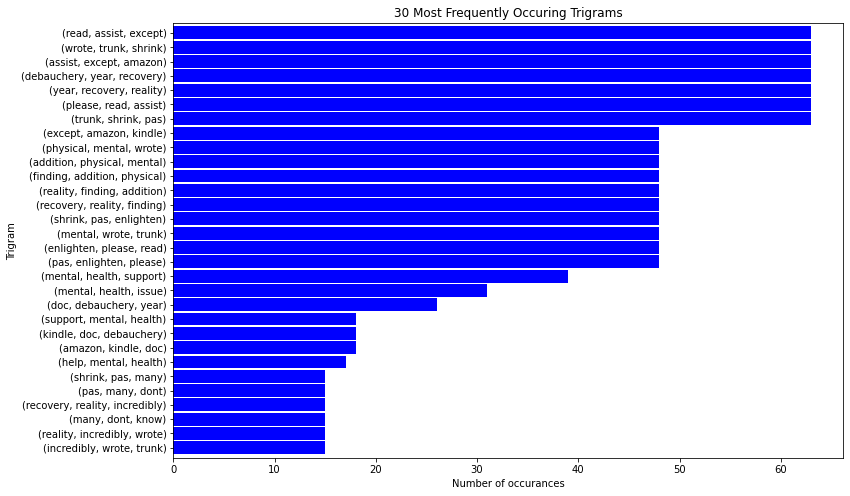

In [63]:
trigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('30 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('Number of occurances')

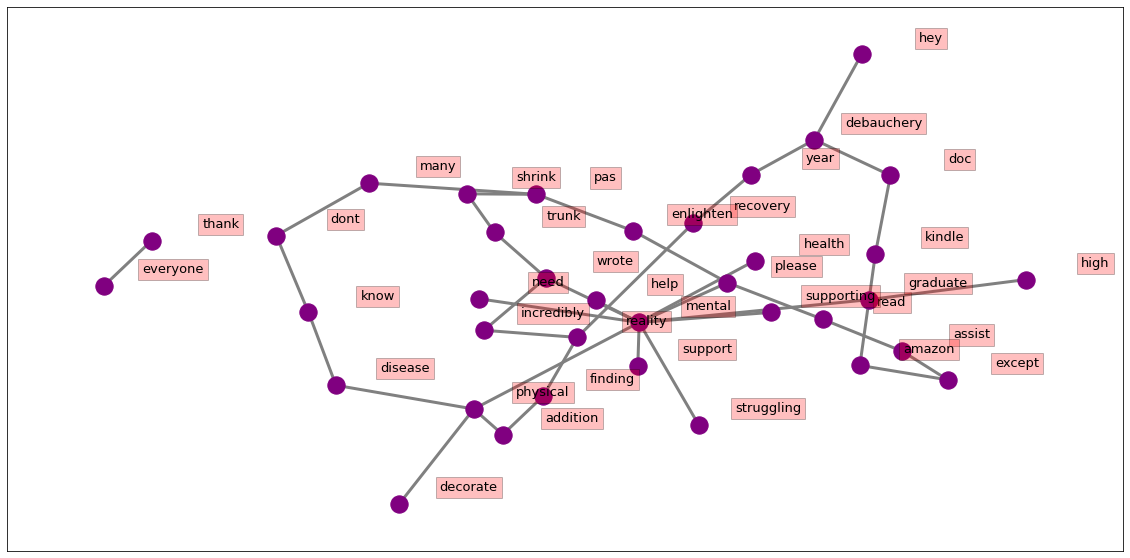

In [64]:
# Create dictionary of bigrams and their counts
d = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:50].to_frame(name='count').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

G.add_node("mental", weight=100)

fig, ax = plt.subplots(figsize=(20, 10))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

In [110]:
data[data.sentiment == 'Negative']['text'].sample(10)

21400                                 What you cited said “4-year graduation rate”....also known as THE AMOUNT OF PEOPLE WHO GRADUATE IN FOUR YEARS.. not the amount of people who graduate from here in total dumbass. \n\nTexas State didn’t teach you how to analyze data I see but you worried about us. https://t.co/DXrUvIELYx
24929                               @ChrisCarrollMD Same can be said for emergency medicine. I work in a busy academic PED that’s a level 1 trauma center with over 75k visits per year. We keep getting told we can augment our staffing with anyone from hospitalists to generalists to allergists. It just doesn’t work that way.
33047                                                                                   @_therealjosh @iankar_ I actually think the hardest part for many is surviving in a new place without a support system and without financial stability. Financial stress can have really bad effects on your health and academic performance
9859                     

In [106]:
data[data.sentiment == 'Positive']['text'].sample(10)

20844               @GradSkoolStrugs I was just discussing this with a Postdoc in my lab the other day. I’ve gone from over enthusiastic optimist to fully depressed and anxious in just two years. I decided to quit cuz I couldn’t handle it but with support from my PI and some friendly faculty I’ve decided to stay...
19958                                             Manipulative ex partner and now this. I just want to graduate and start my dream career and actually use the training of acquired to help and mentor others. These "charges" would stain any application I would have in science and academia. I cannot stress this enough
14652         It's here! #NSD19 Congrats to every ball player who's dreams turn to reality today! All the hard work, blood, swear and tears has paid off! Good luck to you all as you sign a National Letter of Intent to further your academic and athletic careers in college! #NationalSigningDay https://t.co/pYX3xoL6IG
31642                      Acknowledge, open up, 

In [69]:
# creating word frequency count
data['text_nlp']=data['text_nlp'].fillna("")
num_words = 200
word2count_p = {}
word2count_n = {}
for i in tqdm(range(len(data.loc[data.sentiment == 'Positive']['text_nlp']))): 
    for word in data.loc[df.sentiment == 'Positive']['text_nlp'].iloc[i].split():
        if word not in word2count_p.keys(): 
            word2count_p[word] = 1
        else: 
            word2count_p[word] += 1

for i in tqdm(range(len(data.loc[data.sentiment == 'Negative']['text_nlp']))): 
    for word in data.loc[data.sentiment == 'Negative']['text_nlp'].iloc[i].split():
        if word not in word2count_n.keys(): 
            word2count_n[word] = 1
        else: 
            word2count_n[word] += 1
            
freq_words_p = heapq.nlargest(num_words, word2count_p, key=word2count_p.get)
freq_words_n = heapq.nlargest(num_words, word2count_n, key=word2count_n.get)

stopwords = ['iäôve','done','well','its','pad','made','much','take','phdlife','got','know','next','going','new','quite','get', 'far', 'smelter',
            'many','also','dont','phdchat','would','un', 'one','via','youäôre','donna','took','whole','come','academictwitter','mentalhealth']
for word in list(freq_words_p):  
    if word in stopwords:
        freq_words_p.remove(word)
for word in list(freq_words_n):  
    if word in stopwords:
        freq_words_n.remove(word)

/var/folders/ck/3npmnx597nb730qdy5w_6kp00000gn/T/ipykernel_86782/3741944828.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 1018/1018 [00:00<00:00, 1579.53it/s]


In [70]:
# present only in positive
list(set(freq_words_p) - set(freq_words_n))

['helpful',
 'gradschool',
 'supporting',
 'free',
 'helps',
 'god',
 'psychiatric',
 'love',
 'world',
 'encourage',
 'place',
 'learning',
 'ago',
 'important',
 'team',
 'decorate',
 'academicchatter',
 'success',
 'shrinks',
 'talk',
 'postdoc',
 'skill',
 'grateful',
 'except',
 'lets',
 'kindle',
 'happy',
 'finding',
 'supported',
 'proud',
 'addition',
 'amazon',
 'process',
 'debauchery',
 'care',
 'trunks',
 'welling',
 'services',
 'journey',
 'feeling',
 'community',
 'two',
 'great',
 'sure',
 'best',
 'friends',
 'looking',
 'enlighten',
 'share',
 'excited',
 'learn',
 'amazing',
 'taking',
 'everyone',
 'yes',
 'thankful',
 'use',
 'professional',
 'join',
 'burnt',
 'hope',
 'friend',
 'thank',
 'thanks']

In [71]:
# present only in negative
list(set(freq_words_n) - set(freq_words_p))

['thought',
 'cause',
 'hey',
 'enough',
 'post',
 'mon',
 'frustrated',
 'lost',
 'started',
 'finish',
 'shit',
 'insane',
 'tell',
 'tramp',
 'wrong',
 'went',
 'actually',
 'stop',
 'home',
 'thing',
 'times',
 'ill',
 'pressure',
 'kind',
 'there',
 'granulation',
 'suicide',
 'ask',
 'write',
 'doesn',
 'news',
 'science',
 'assistant',
 'incredibly',
 'real',
 'yet',
 'another',
 'exhausted',
 'masters',
 'all',
 'look',
 'due',
 'thinking',
 'man',
 'able',
 'bad',
 'told',
 'end',
 'financial',
 'dad',
 'crisis',
 'literally',
 'system',
 'depressed',
 'adviser',
 'let',
 'that',
 'pay',
 'he',
 'makes',
 'asked',
 'desperate']

In [72]:
def common_member(a, b):
    a_set = set(a)
    b_set = set(b)
 
    if (a_set & b_set):
        print(a_set & b_set)
    else:
        print("No common elements")
common_member(freq_words_n, freq_words_p)

{'start', 'anyone', 'help', 'anxiety', 'years', 'degree', 'writing', 'depression', 'stressed', 'therapist', 'trauma', 'say', 'long', 'need', 'even', 'physical', 'someone', 'see', 'life', 'class', 'time', 'suppurative', 'glad', 'like', 'health', 'experience', 'part', 'please', 'sad', 'still', 'your', 'pass', 'always', 'stress', 'little', 'lot', 'college', 'could', 'every', 'student', 'around', 'distressful', 'family', 'others', 'assist', 'helped', 'want', 'never', 'good', 'people', 'didn', 'students', 'days', 'right', 'back', 'trying', 'worried', 'make', 'better', 'reality', 'recovery', 'program', 'helping', 'graduate', 'mental', 'kiss', 'last', 'feel', 'children', 'dissertation', 'way', 'crazy', 'career', 'cry', 'needs', 'working', 'read', 'paid', 'give', 'support', 'year', 'school', 'education', 'hear', 'wrote', 'months', 'said', 'week', 'first', 'high', 'can', 'issues', 'thesis', 'things', 'university', 'without', 'today', 'academic', 'day', 'think', 'getting', 'therapy', 'may', 'eve

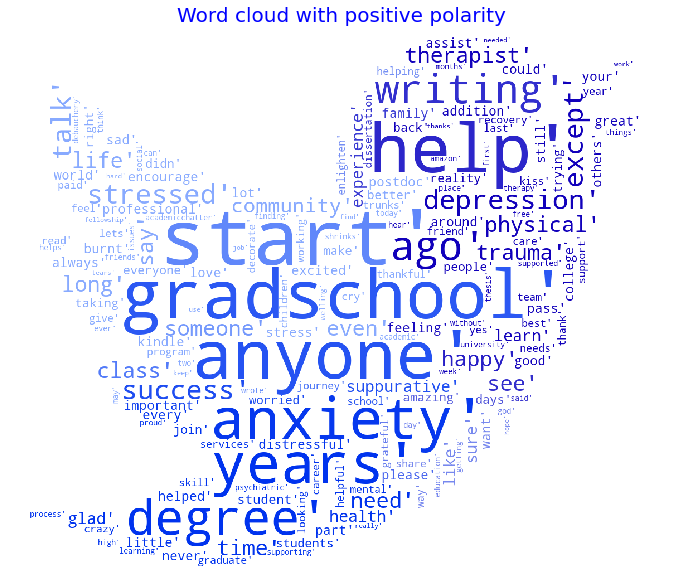

In [73]:
wordcloud = WordCloud(width=600, height=500, random_state=1, max_words=num_words, 
                          min_font_size=10,  max_font_size=140,
                          background_color='white',stopwords=set(STOPWORDS),mask = mask)
wordcloud.generate(str(set(freq_words_p)))

image_colors = ImageColorGenerator(blue)
plt.figure(figsize=(20,10))
plt.title("Word cloud with positive polarity", fontsize=20,color='#0000FF')
plt.imshow(wordcloud, interpolation='bilinear')
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='None')
plt.axis('off')
plt.show()

In [74]:
#wordcloud.to_file('pictures/twitter_supervision_full.png')

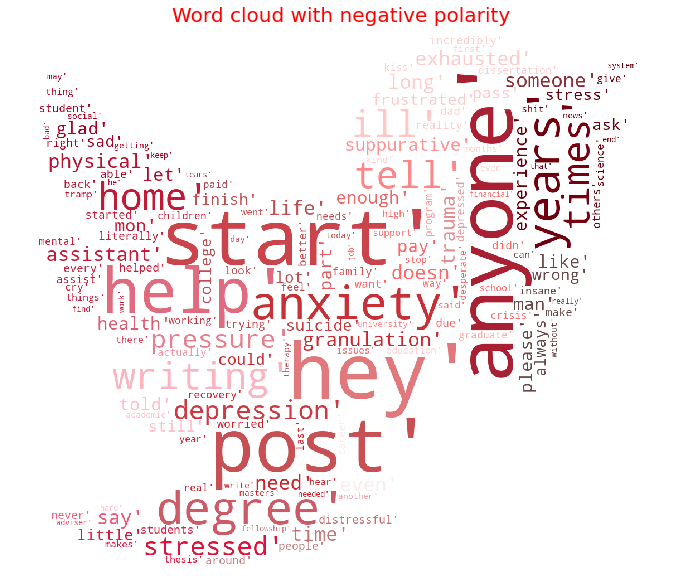

In [75]:
wordcloud = WordCloud(width=600, height=500, random_state=1, max_words=num_words, 
                          min_font_size=10,  max_font_size=140,
                          background_color='white',stopwords=set(STOPWORDS),mask = mask)
wordcloud.generate(str(set(freq_words_n)))

image_colors = ImageColorGenerator(red)
plt.figure(figsize=(20,10))
plt.title("Word cloud with negative polarity", fontsize=20,color='red')
plt.imshow(wordcloud, interpolation='bilinear')
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='None')
plt.axis('off')
plt.show()

In [76]:
#wordcloud.to_file('pictures/twitter_supervision_full_neg.png')